In [1]:
import scipy.io
from pylab import *
from matplotlib import *
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from operator import add
pd.options.mode.chained_assignment = None

## Converting Data to CSV

In [2]:
def convert_to_df(file):
    # use scipy to load matlab file
    matlab_data = scipy.io.loadmat('data/' + str(file))
    
    # create dataframe and transpose
    df = pd.DataFrame(matlab_data['all_data']).T
    
    # create column headers
    df.columns = [
        'Mean Area Under Heart Beat',
        'Mean R-to-R Peak Interval',
        'Heart Rate',
        'Peak to Peak Blood Pressure',
        'Systolic Blood Pressure',
        'Diastolic Blood Pressure',
        'Pulse Pressure'
    ]
    
    # add labels column
    df['Golden Alarms'] = matlab_data['all_labels'][0]
    
    return df

filenames = ['1_a41178.mat', '2_a42126.mat', '3_a40076.mat', \
             '4_a40050.mat', '5_a41287.mat', '6_a41846.mat', \
             '7_a41846.mat', '8_a42008.mat', '9_a41846.mat']

patient_data = [convert_to_df(file) for file in filenames]

# floor all data
for df in patient_data:
    for c in df.columns:
        df[c] = df[c].apply(np.floor)
        df[c] = df[c].apply(int)

## Task 0 - Splitting Data

In [3]:
# create arrays to hold train and test dataframes for each patient
train_data = []
test_data = []

for df in patient_data:
    # get split index
    total = len(df)
    split_idx = int(total * 2 / 3)
    
    # append [0, split_idx) to train_data
    train_data.append(df.head(split_idx))
    
    # append [split_idx, total) to test data
    test_data.append(df.tail(total - split_idx))

## Task 1.1a - Generating Prior Probabilities

In [4]:
prior_probabilities = pd.DataFrame(columns=['PH0', 'PH1'])

for i, patient in enumerate(train_data):
    PH1 = patient['Golden Alarms'].sum() / len(patient['Golden Alarms'])
    PH0 = 1 - PH1
    prior_probabilities.loc[i] = [PH0, PH1]

prior_probabilities

,PH0,PH1
0,0.973482,0.026518
1,0.983653,0.016347
2,0.997905,0.002095
3,0.997507,0.002493
4,0.998954,0.001046
5,0.978230,0.021770
6,0.982897,0.017103
7,0.992210,0.007790
8,0.978230,0.021770


These are the prior probabilities for each patient

## Task 1.1b - Constructing Likelihood Matrix

In [5]:
# 9 x 6 matrix of dataframes
likelihood_matrix = []

for patient in train_data:
    # get patient data for each hypothesis
    h1 = patient[patient['Golden Alarms'] == 1]
    h0 = patient[patient['Golden Alarms'] == 0]
        
    # generate likelihood matrix for each patient
    patient_likelihood_matrix = []

    # drop golden alarms
    columns = patient.columns.drop('Golden Alarms')

    for col in columns:
        # get unique value counts for each feature
        # scale by length of patient dataframe hypothesis to get probability
        h0_val_counts = h0[col].value_counts() / len(h0)
        h1_val_counts = h1[col].value_counts() / len(h1)
        
        patient_likelihood_dataframe = pd.DataFrame([h0_val_counts, h1_val_counts]).T
        patient_likelihood_dataframe.columns = ['%s H0' % col, '%s H1' % col]
        
        patient_likelihood_dataframe.fillna(0, inplace=True)
        
        # append to patient likelihood matrix
        patient_likelihood_matrix.append(patient_likelihood_dataframe)
        
    # append patient likelihood matrix to likelihood matrix
    likelihood_matrix.append(patient_likelihood_matrix)

## Task 1.1c - Plotting Features

In [6]:
features = [
    'Mean Area Under Heart Beat',
    'Mean R-to-R Peak Interval',
    'Heart Rate',
    'Peak to Peak Blood Pressure',
    'Systolic Blood Pressure',
    'Diastolic Blood Pressure',
    'Pulse Pressure'
]

In [7]:
plots = []
for patient_index, patient in enumerate(likelihood_matrix):
    for feature_index, feature in enumerate(patient):
        fig, ax = plt.subplots(figsize=(15, 10))
        plt.plot(feature.index, feature[feature.columns[0]])
        plt.plot(feature.index, feature[feature.columns[1]])
        ax.legend(['H0', 'H1'])
        ax.set_title('Patient %d - %s' % (patient_index, columns[feature_index]))
        plots.append(ax)

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


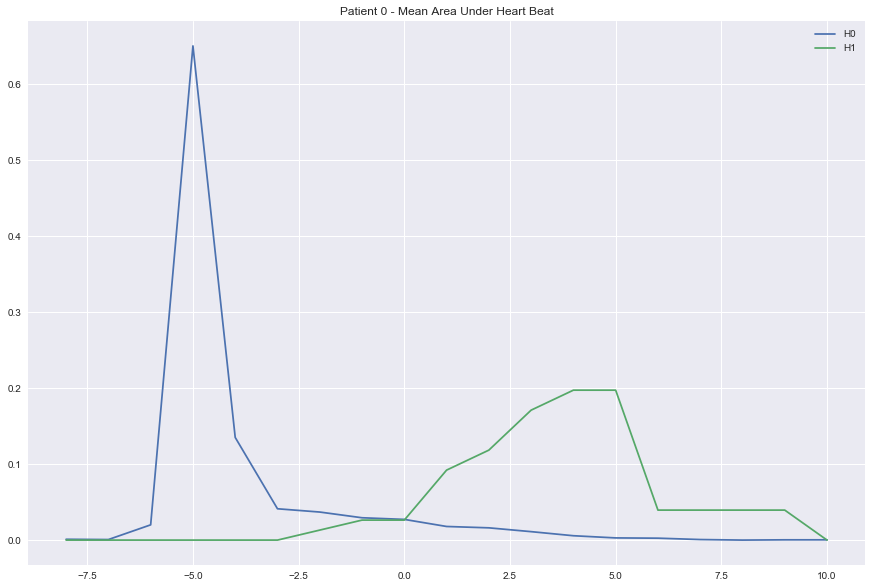

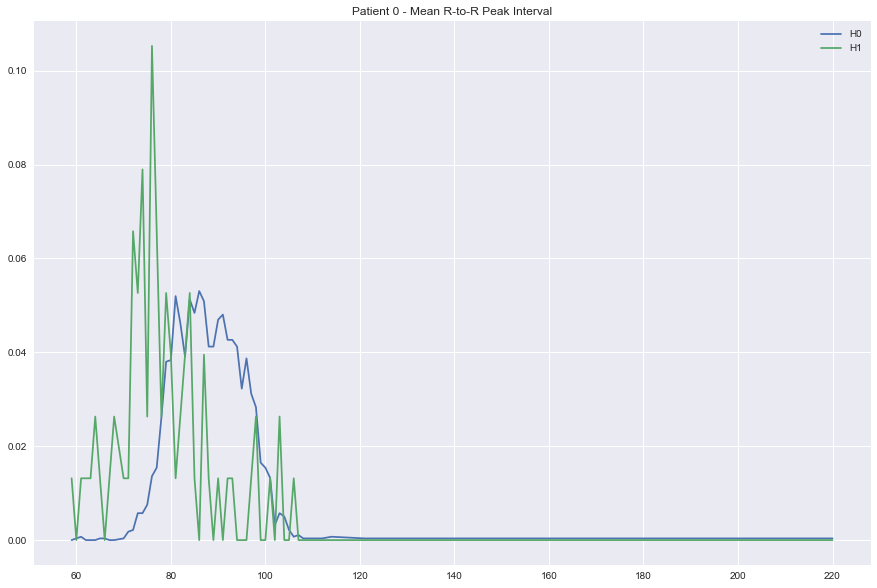

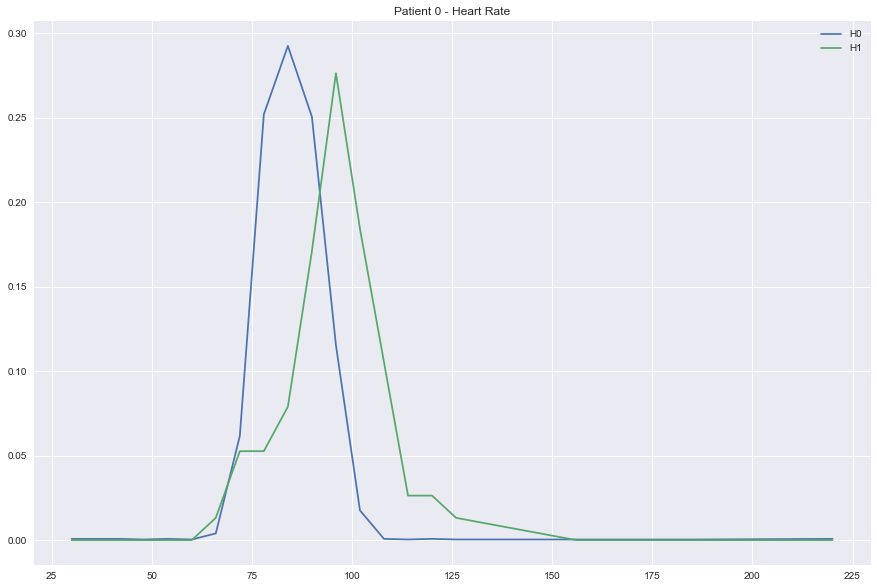

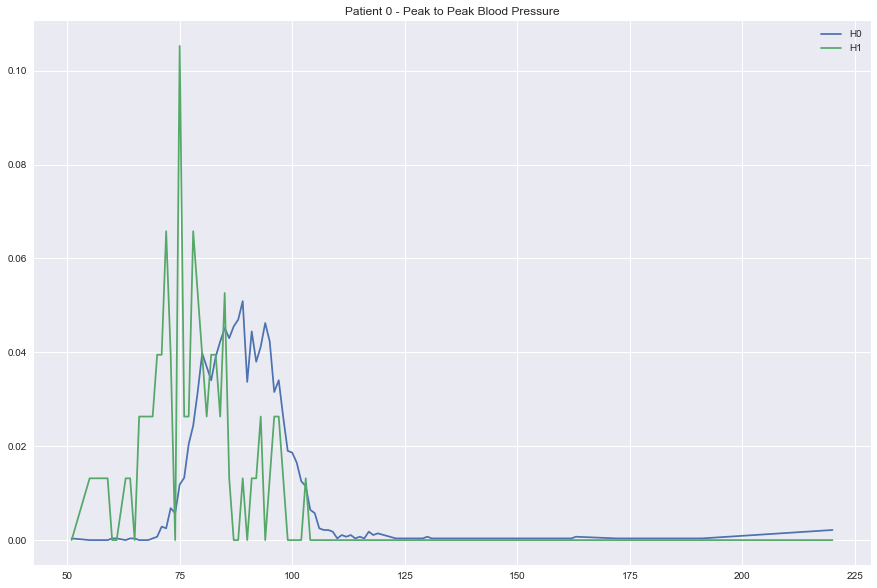

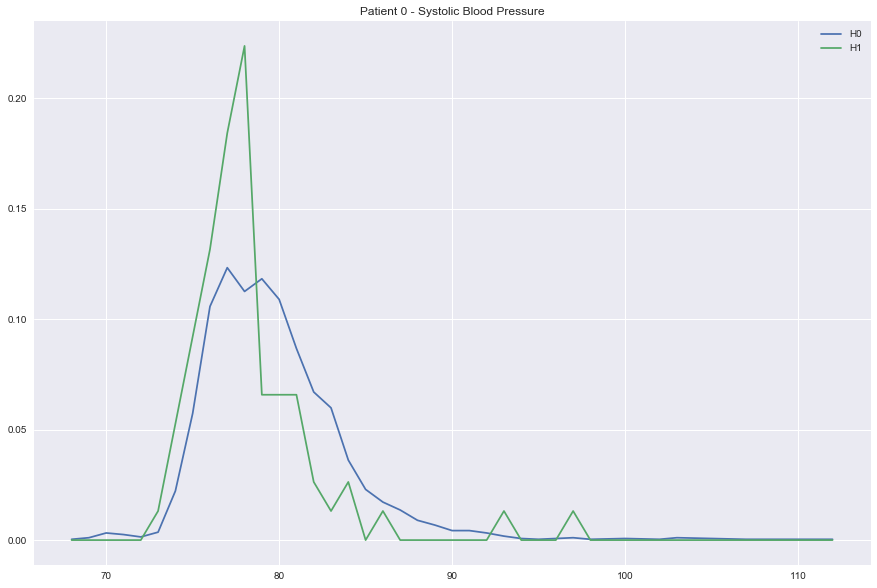

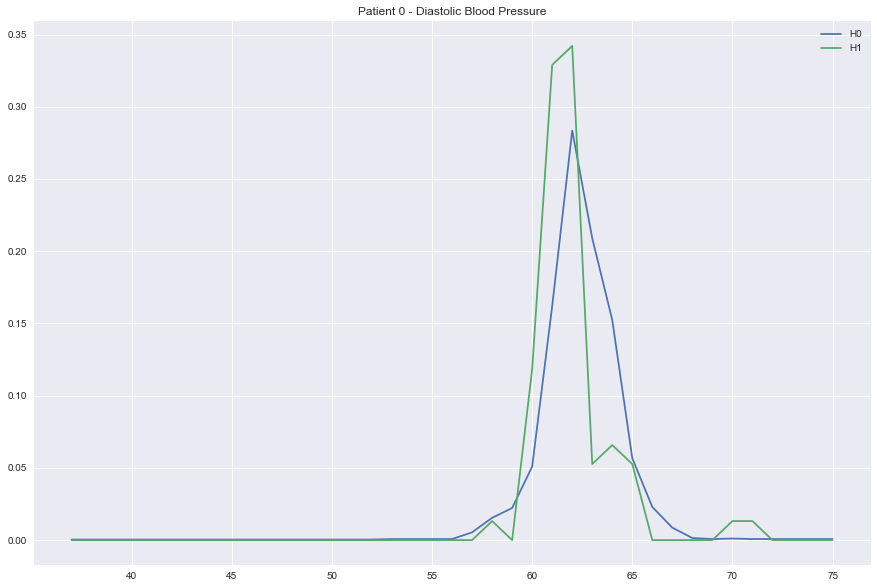

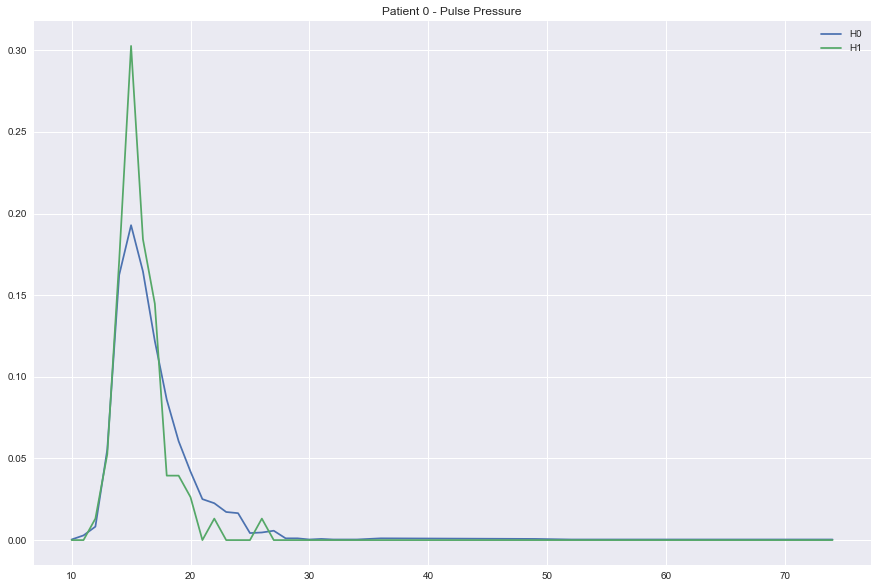

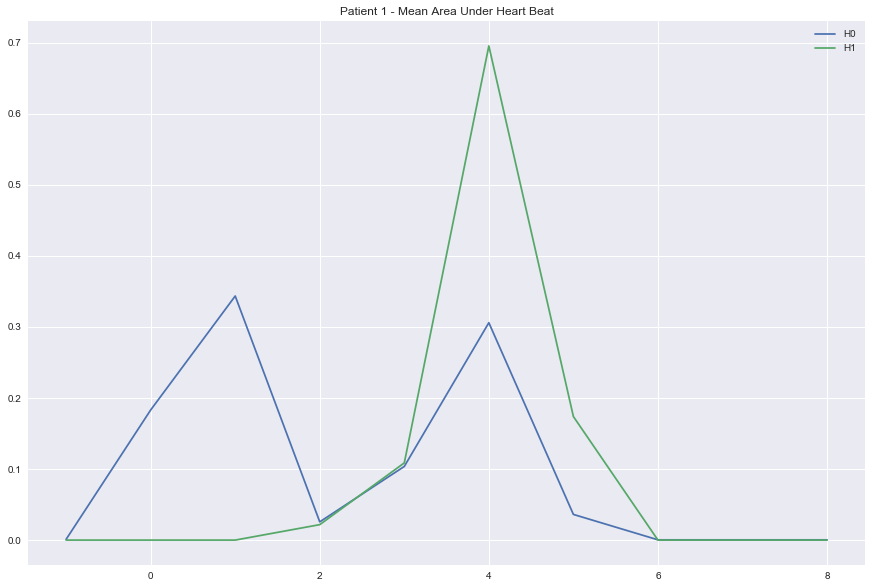

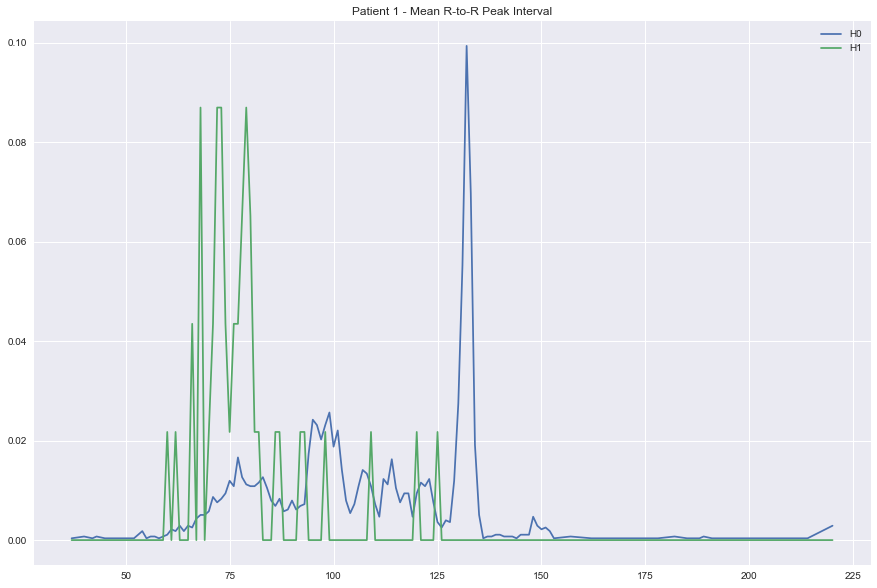

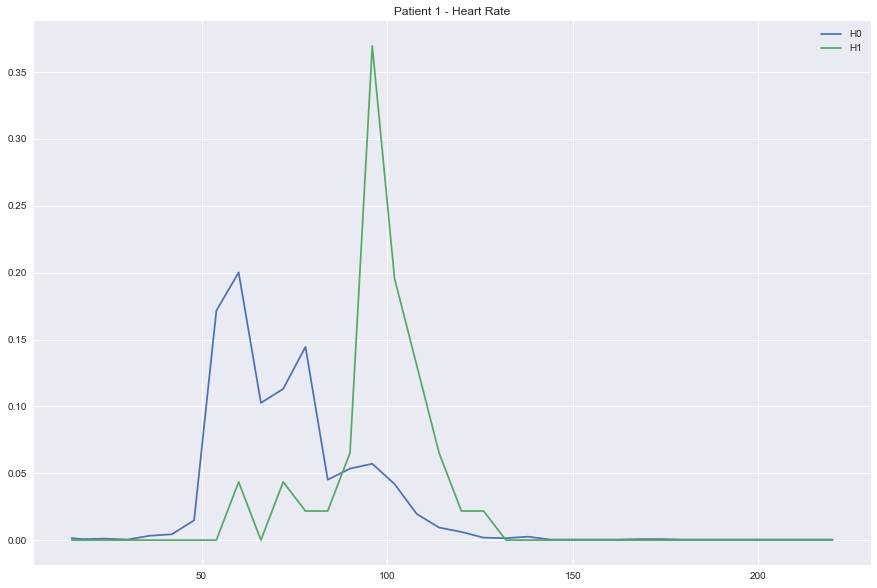

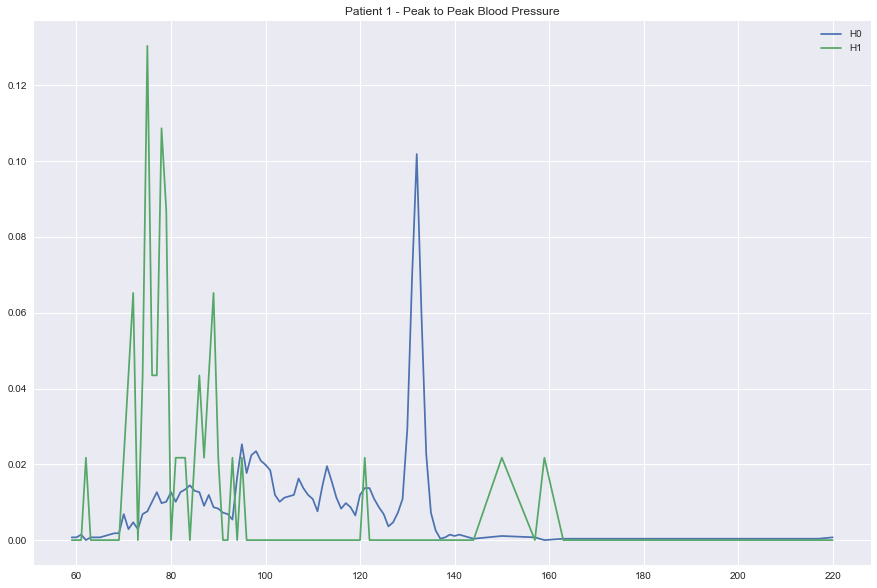

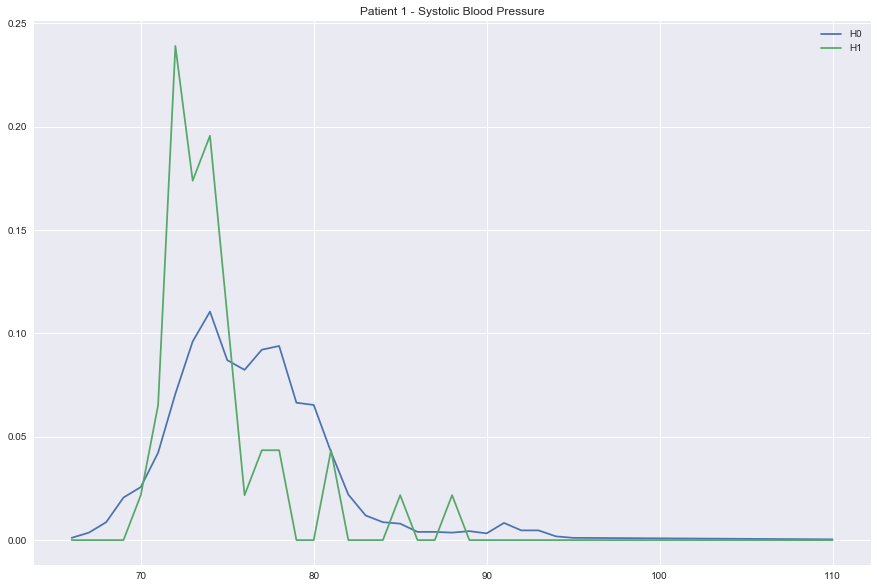

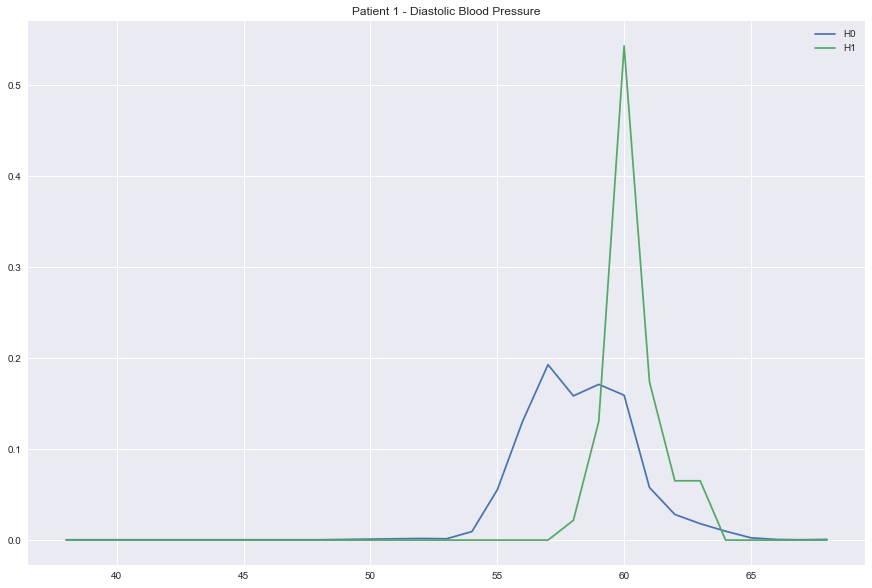

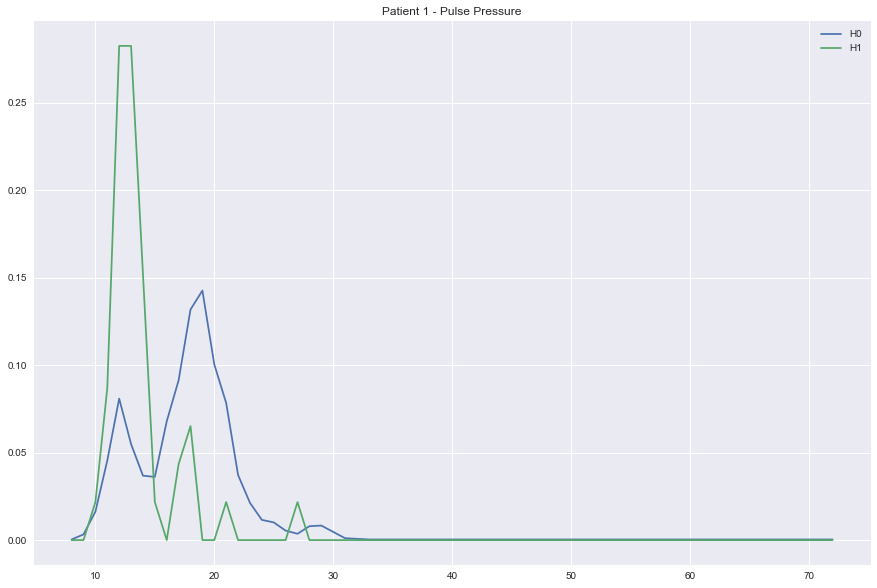

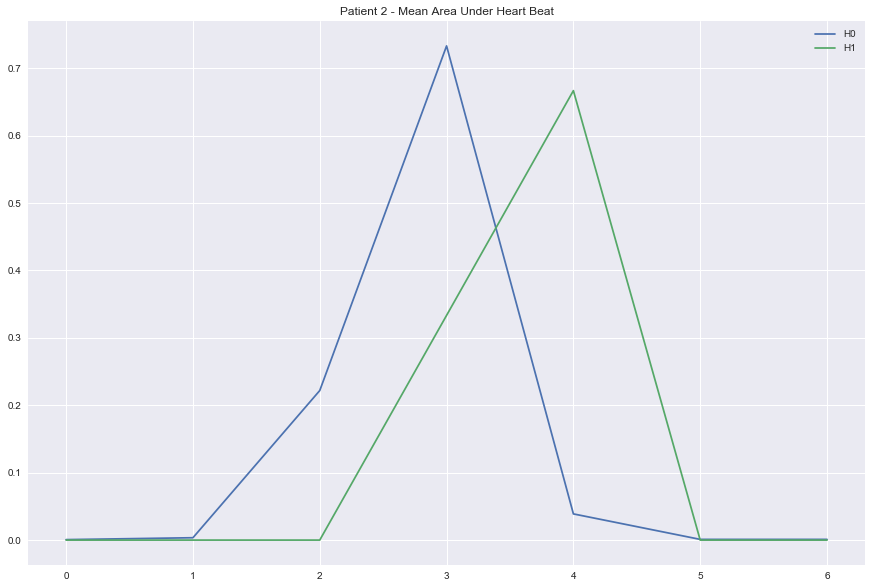

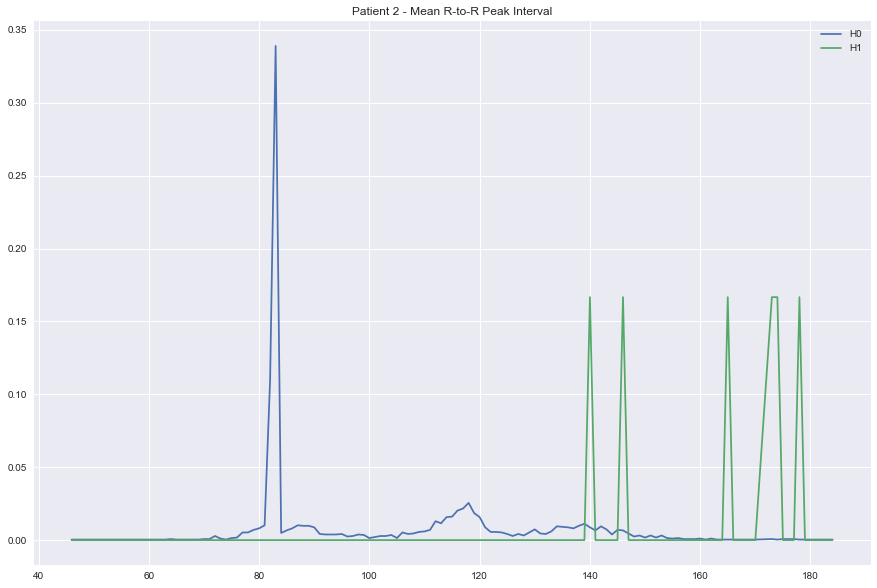

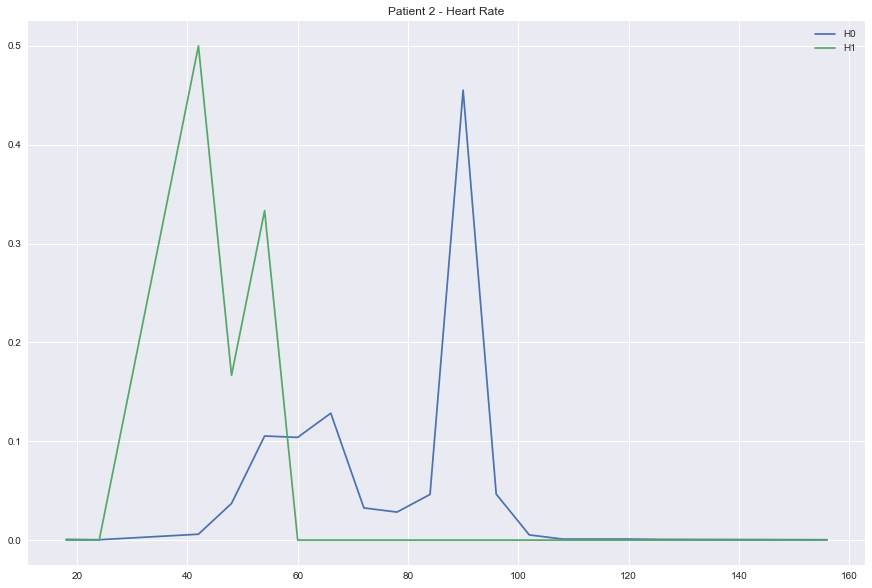

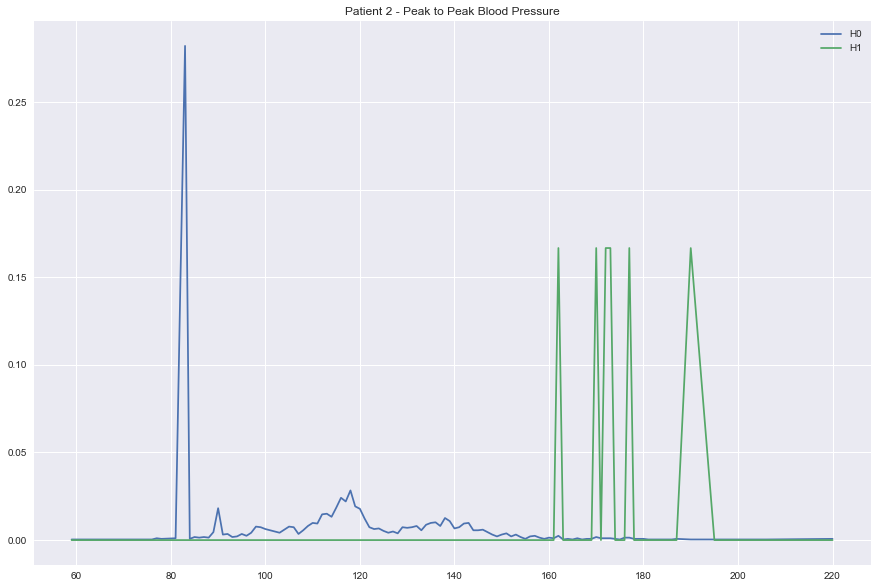

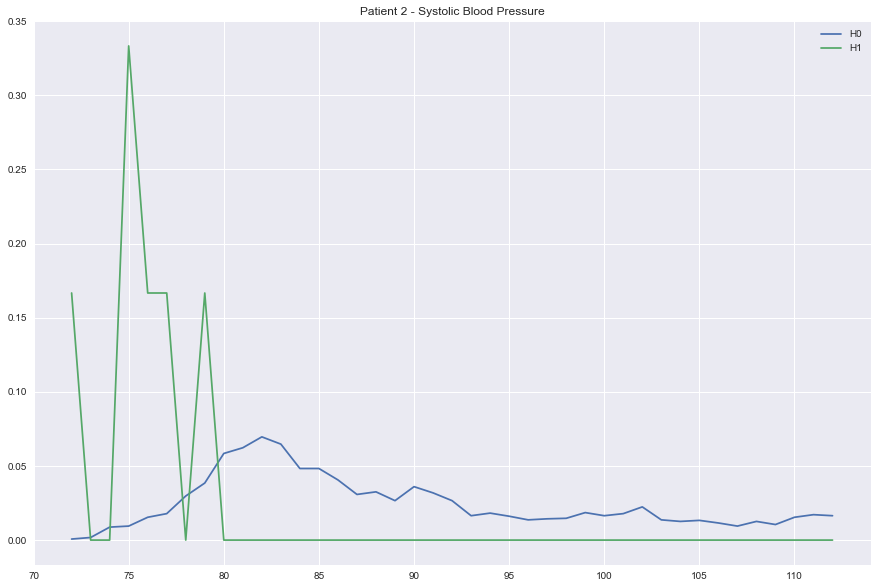

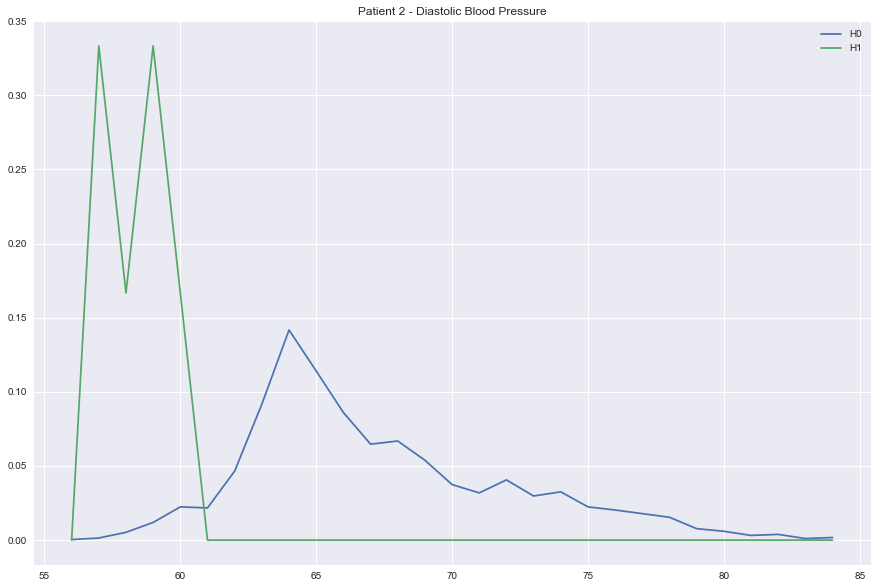

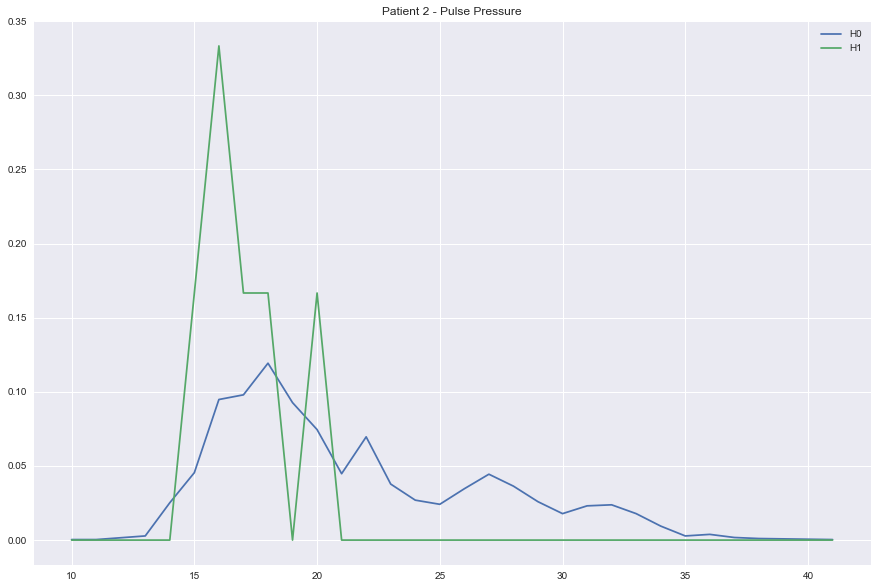

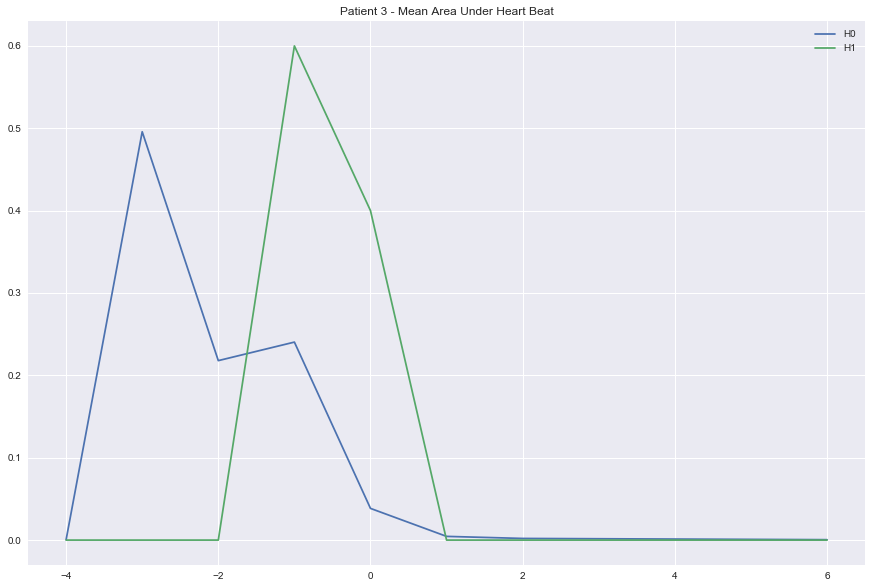

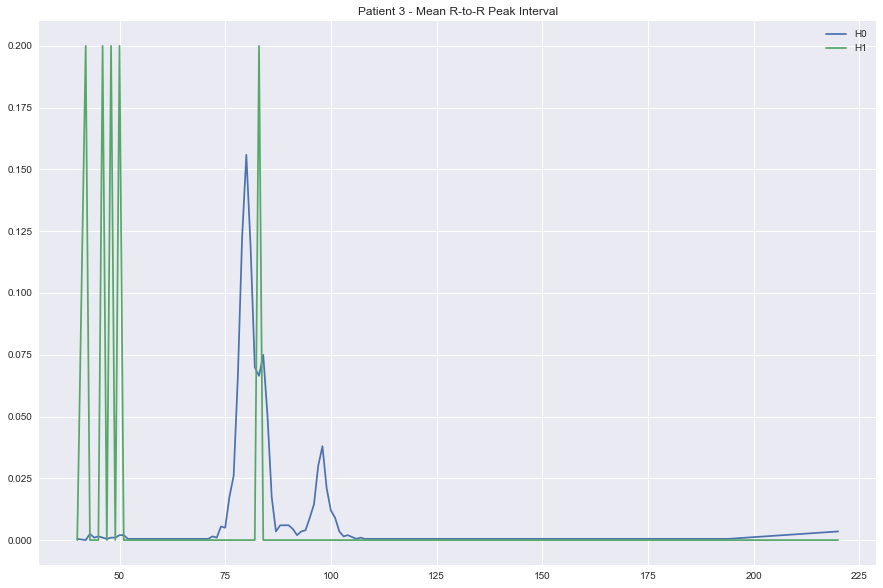

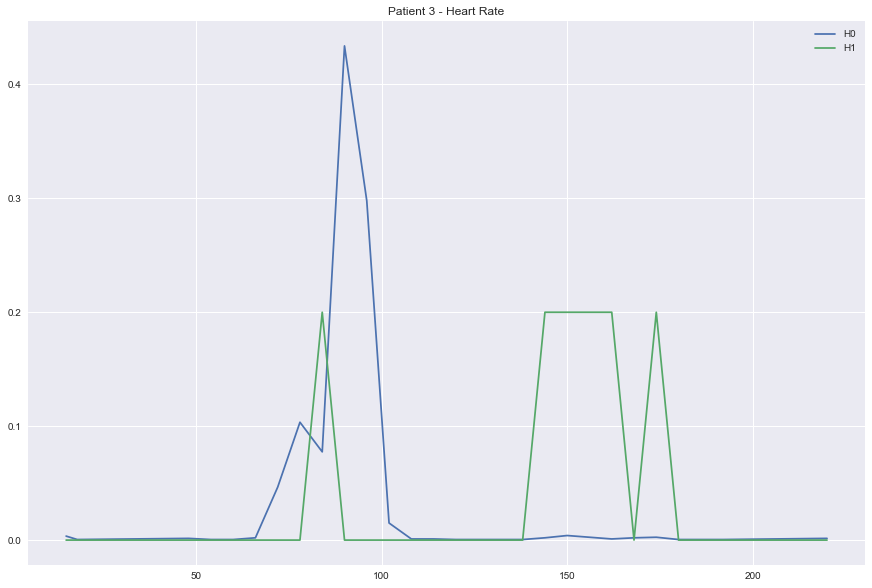

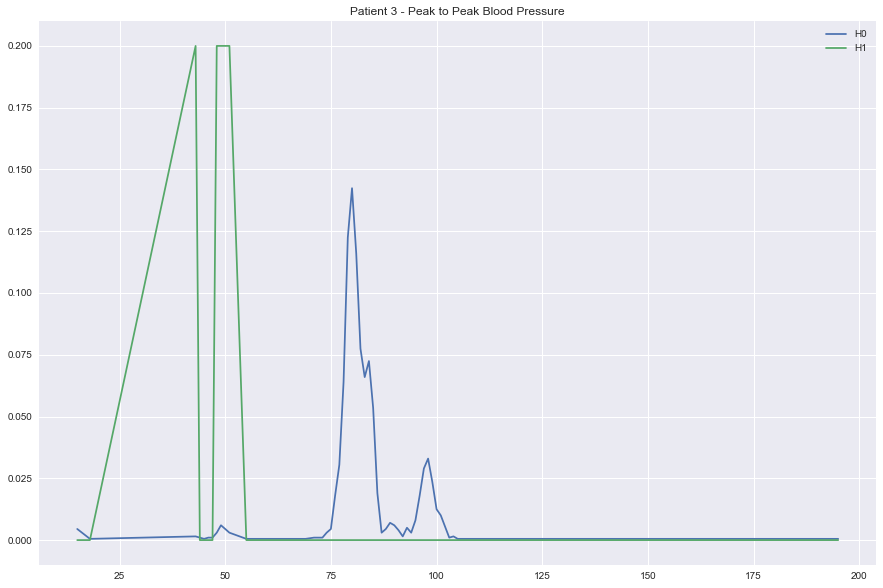

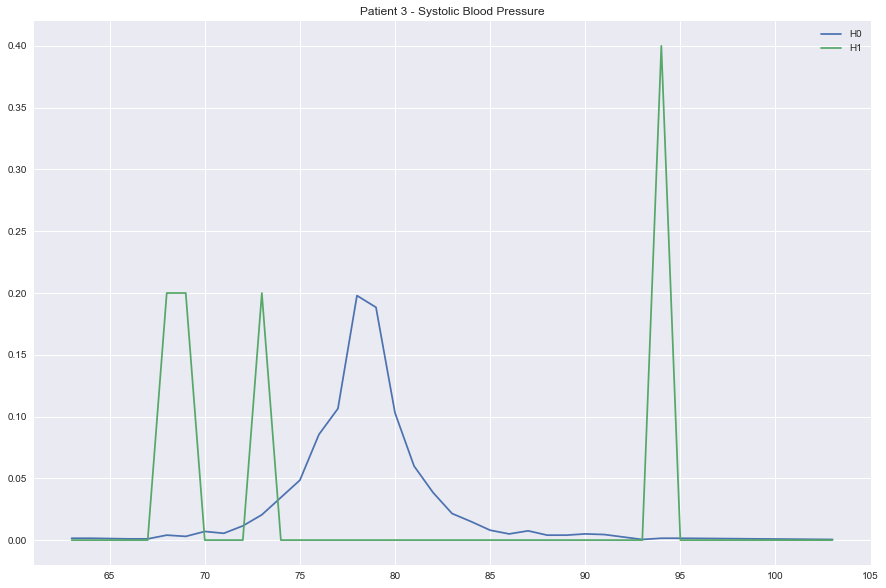

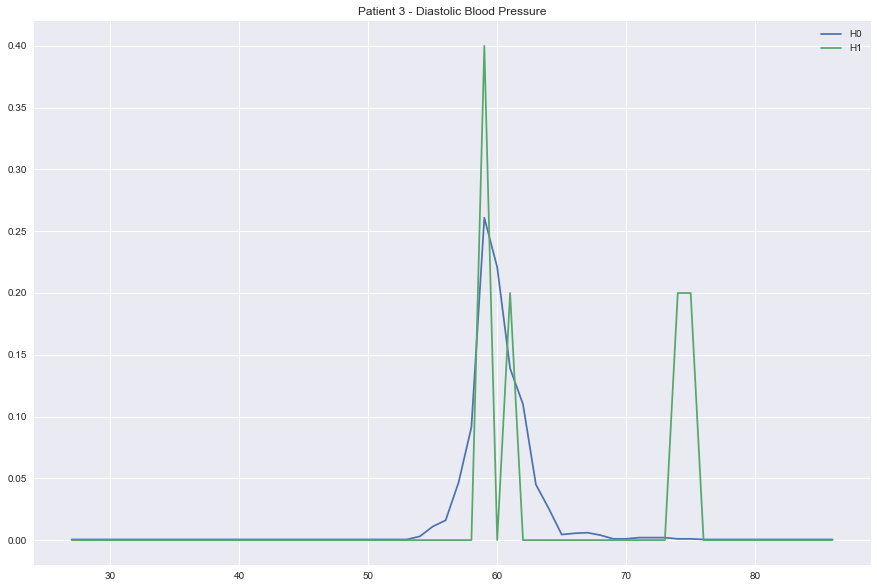

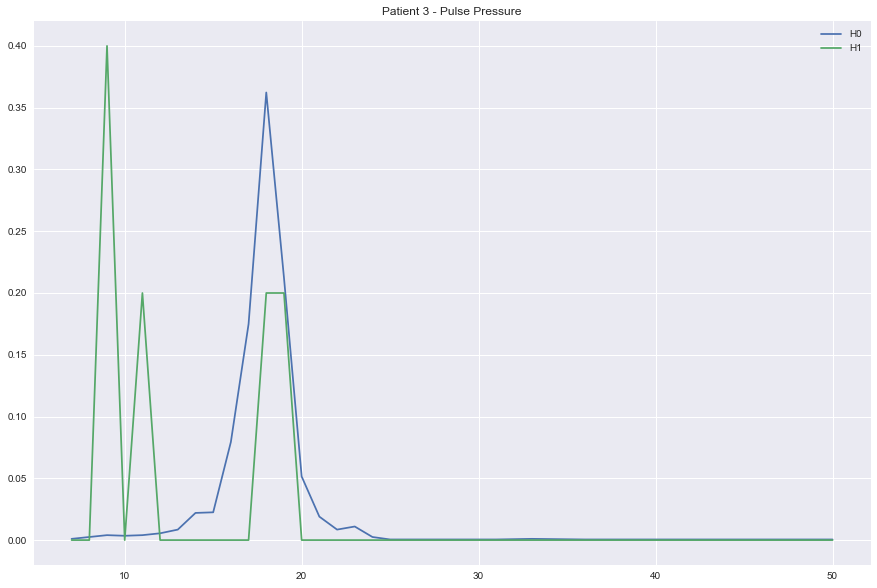

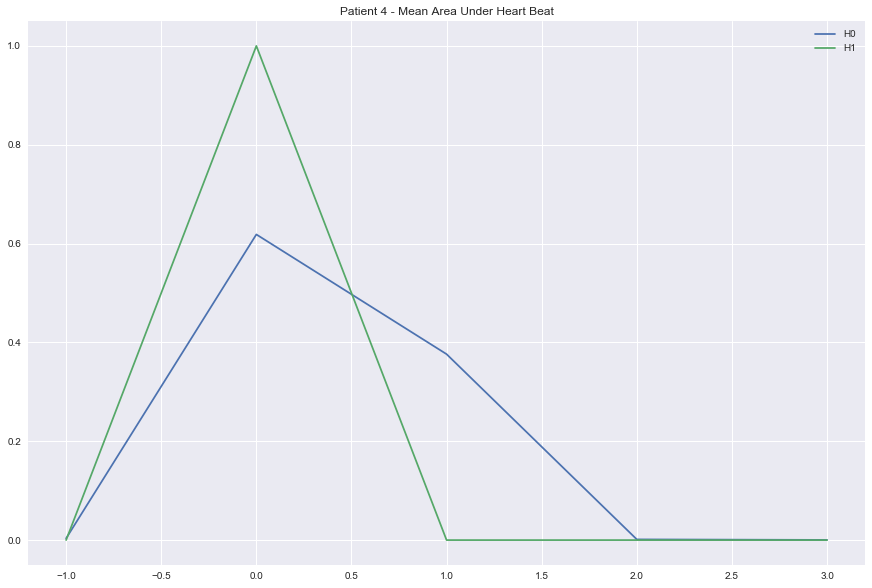

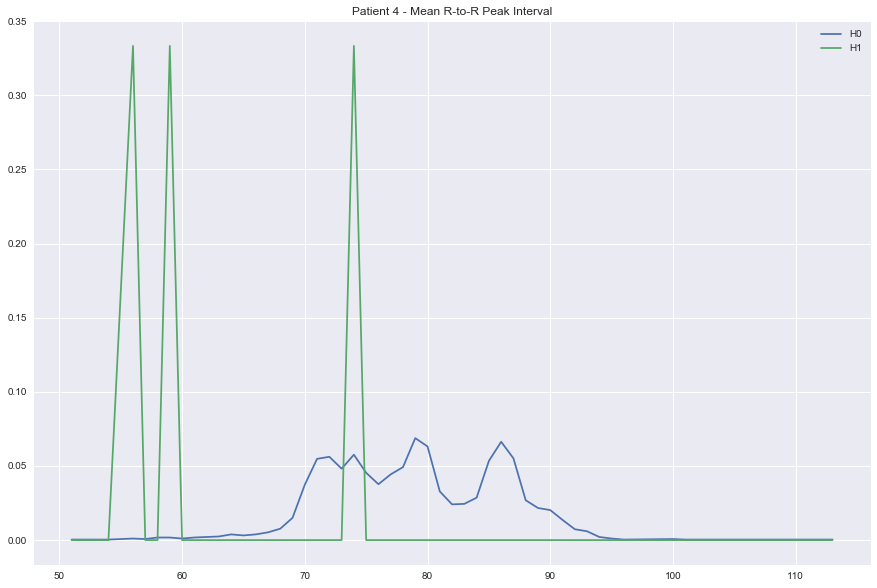

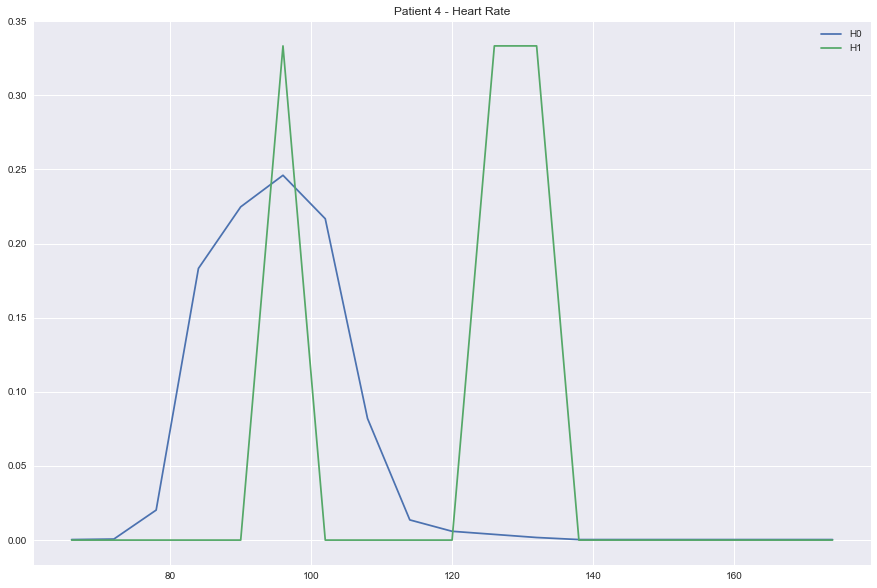

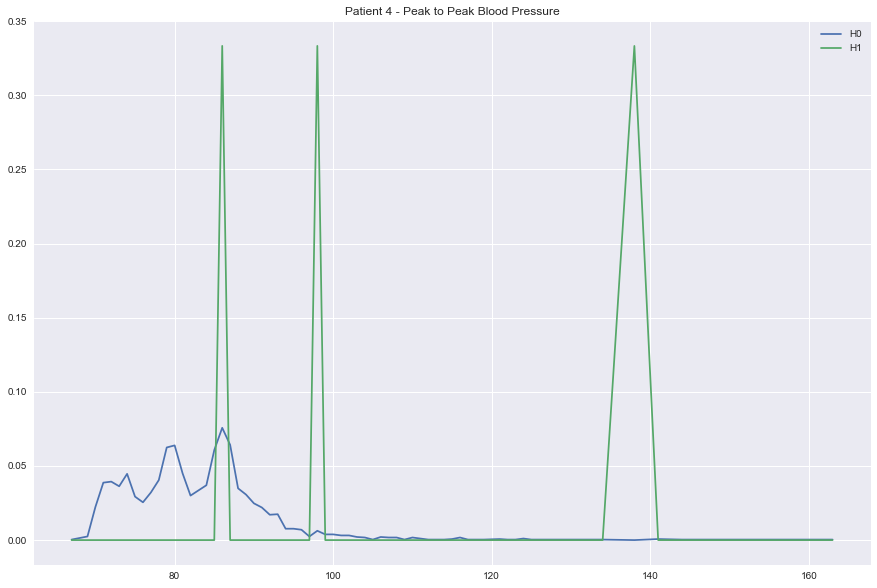

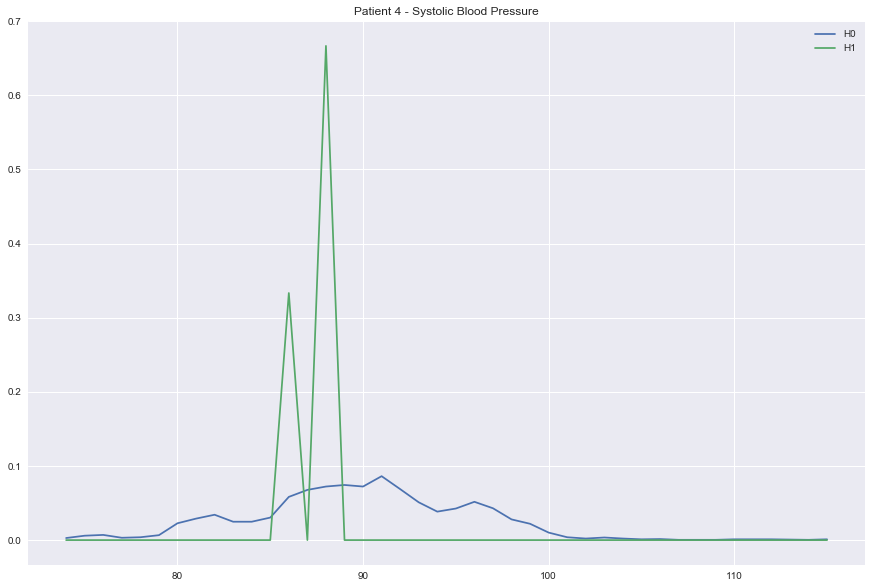

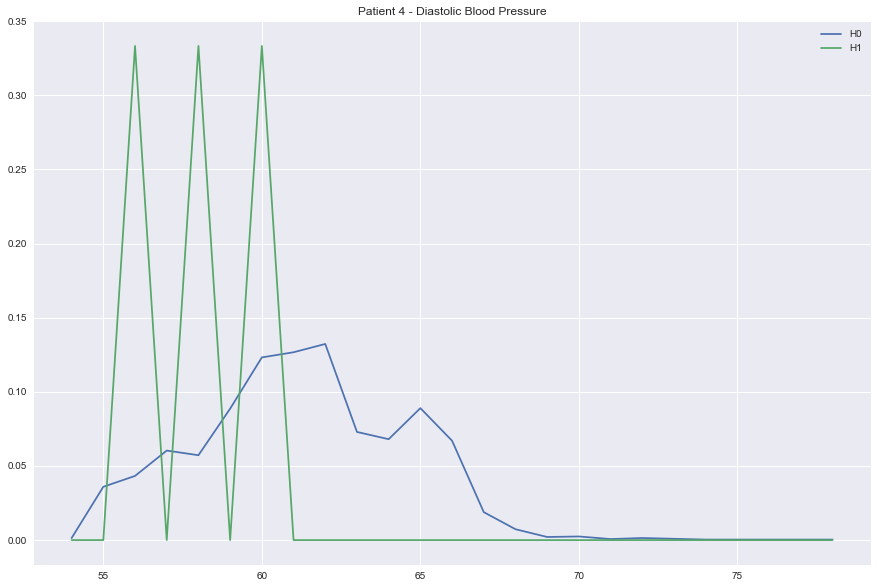

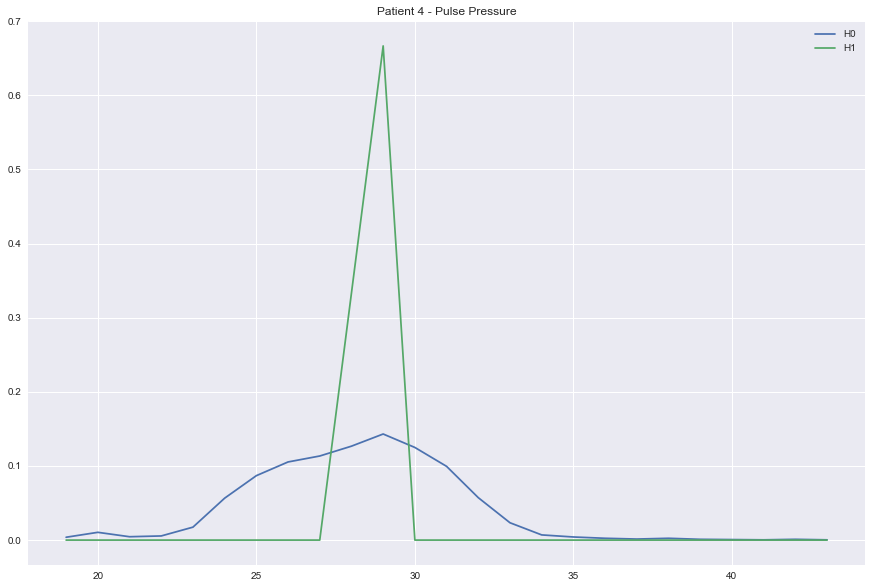

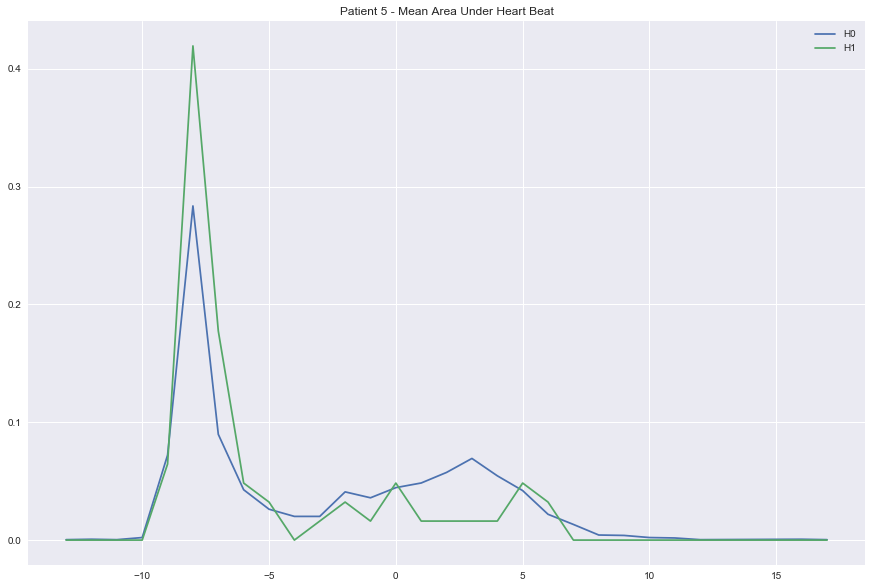

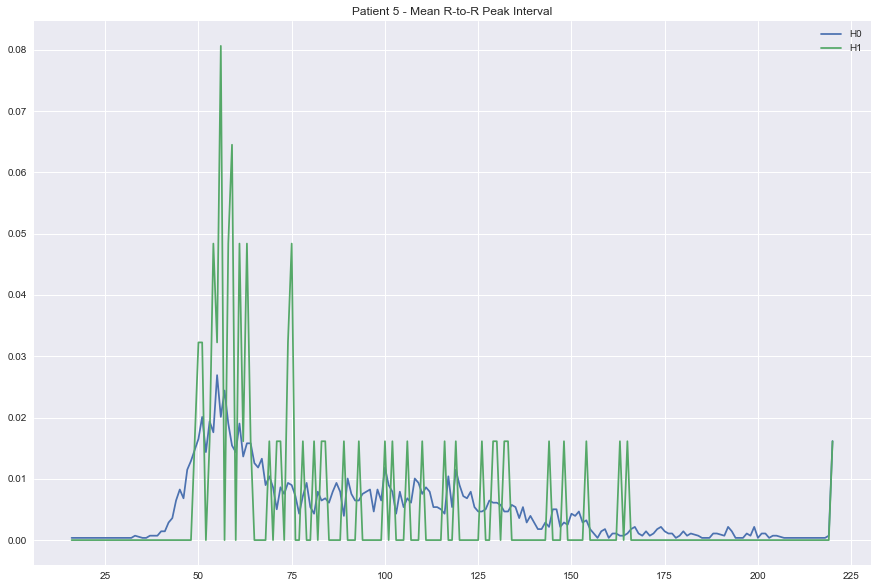

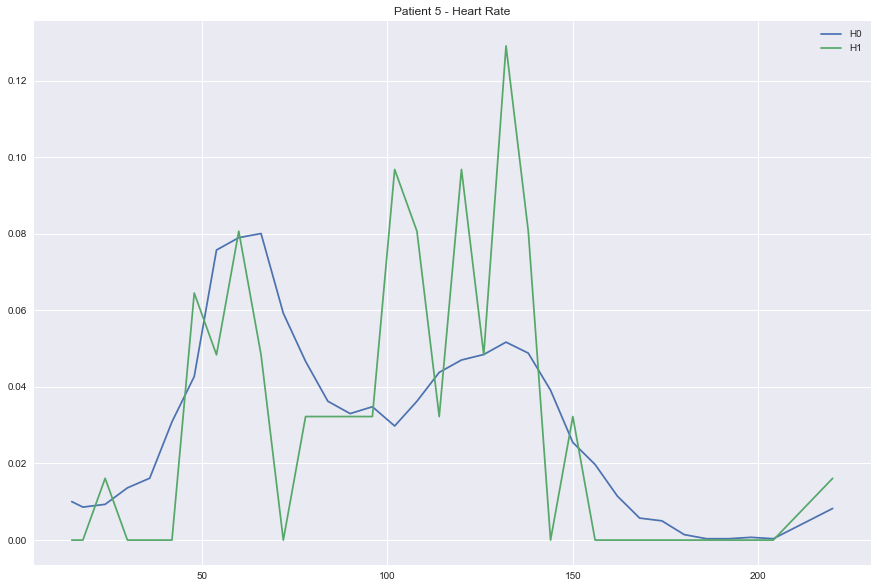

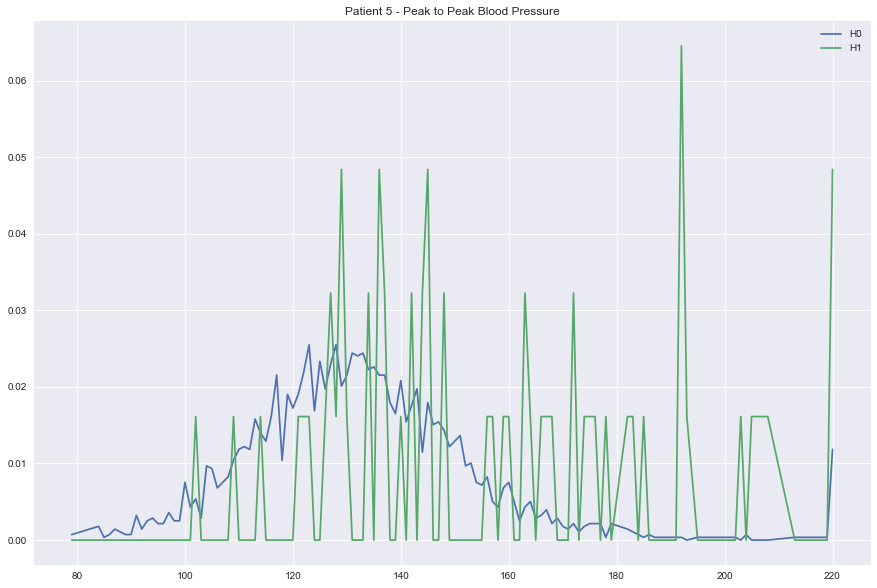

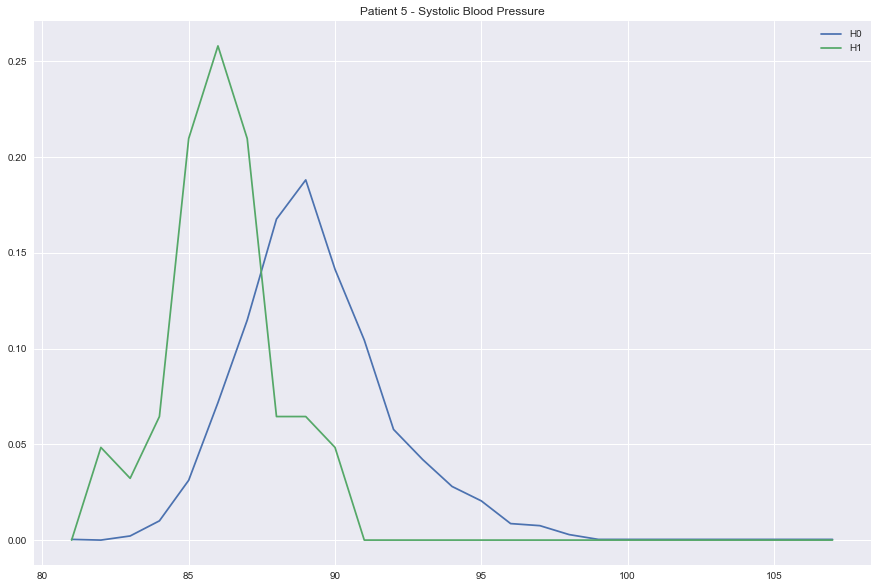

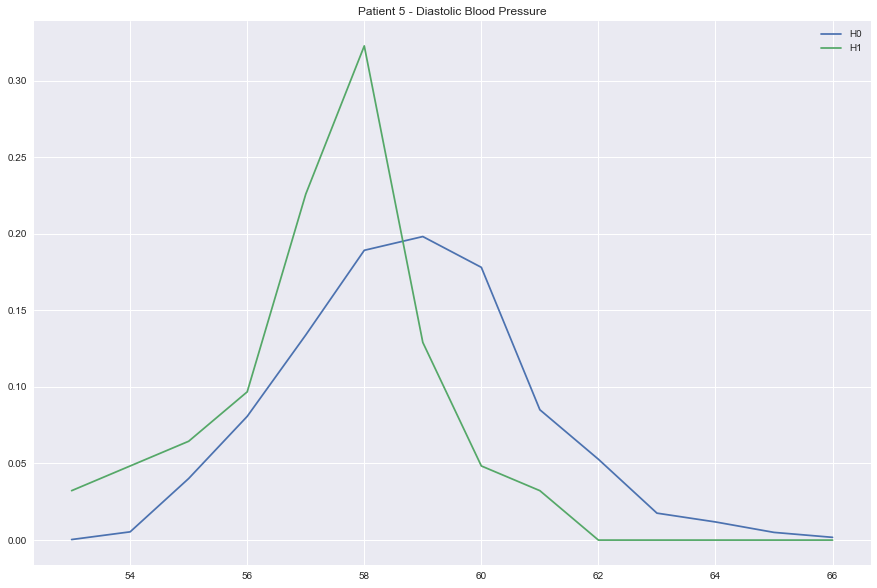

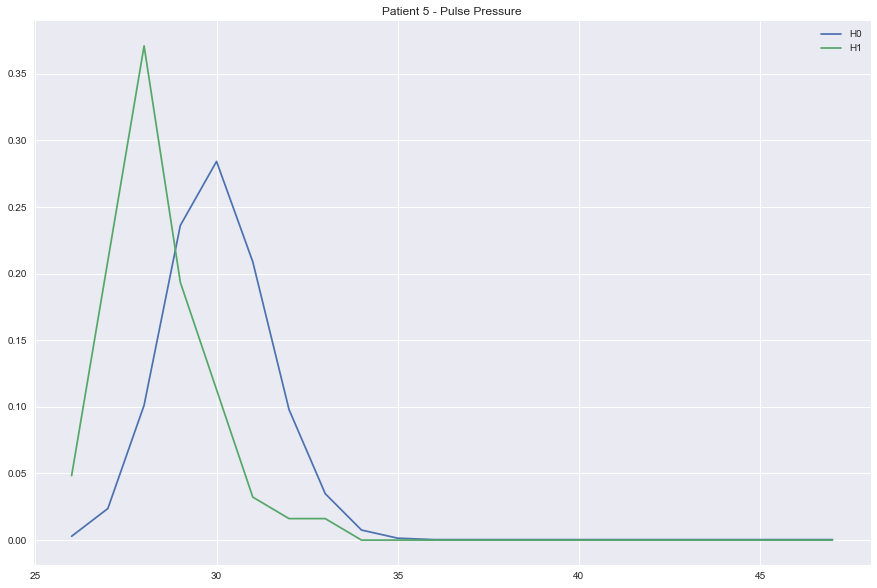

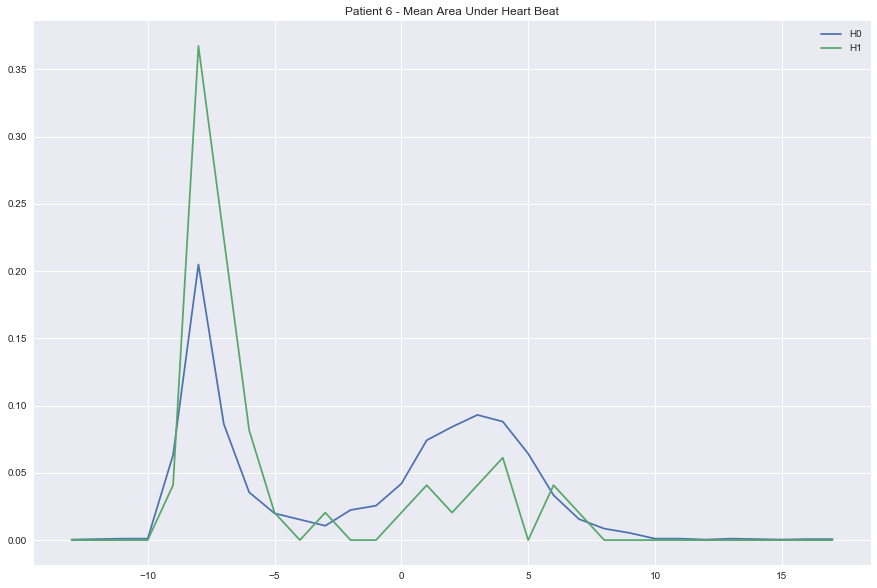

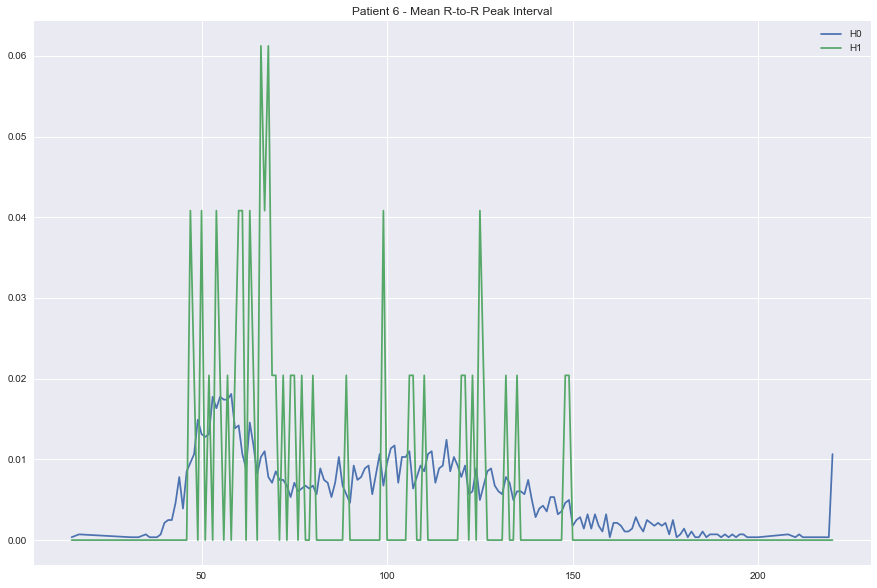

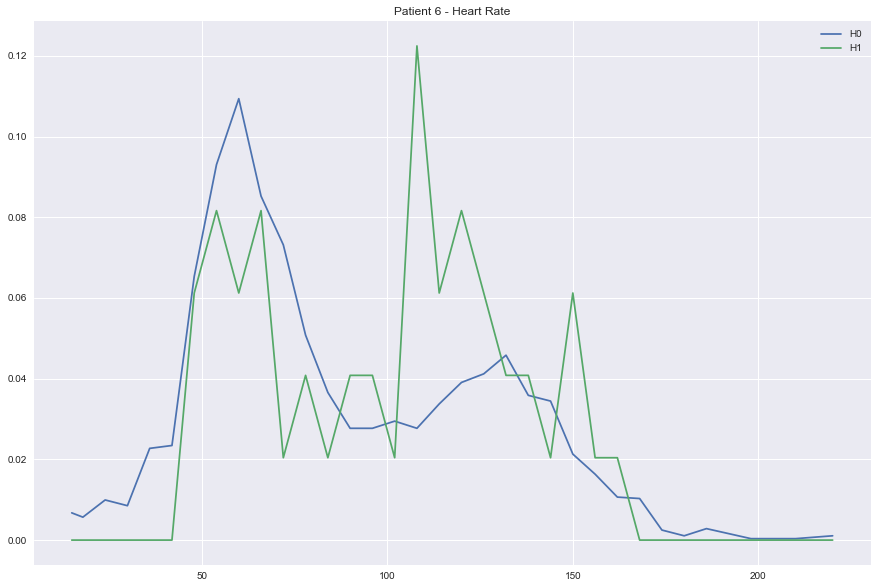

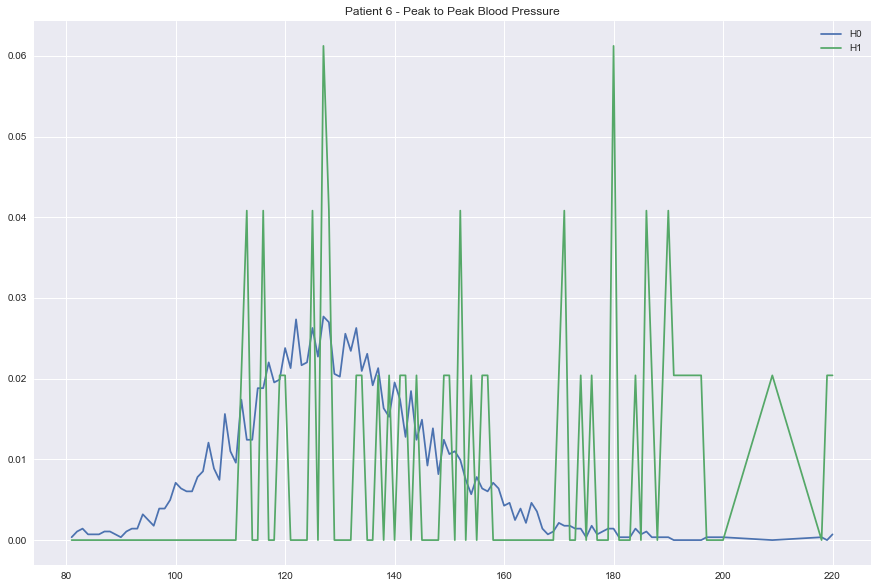

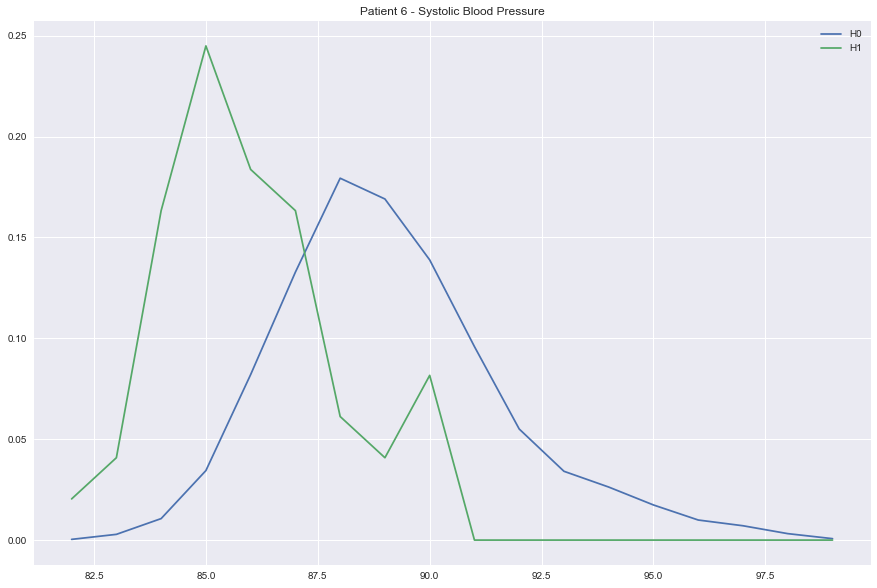

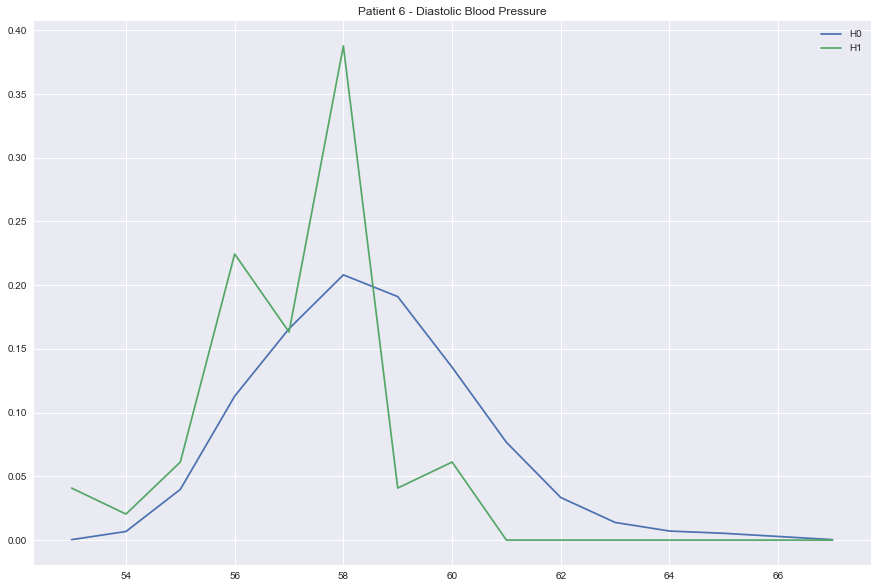

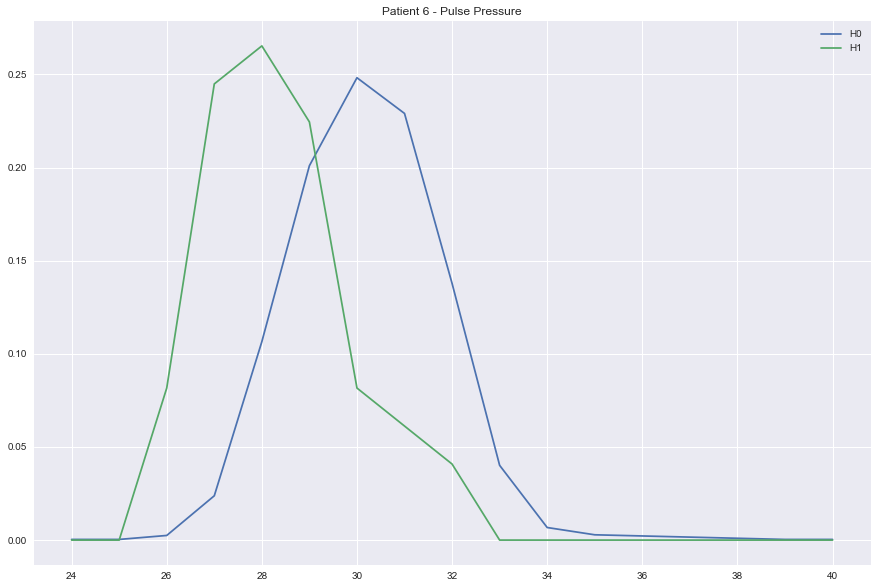

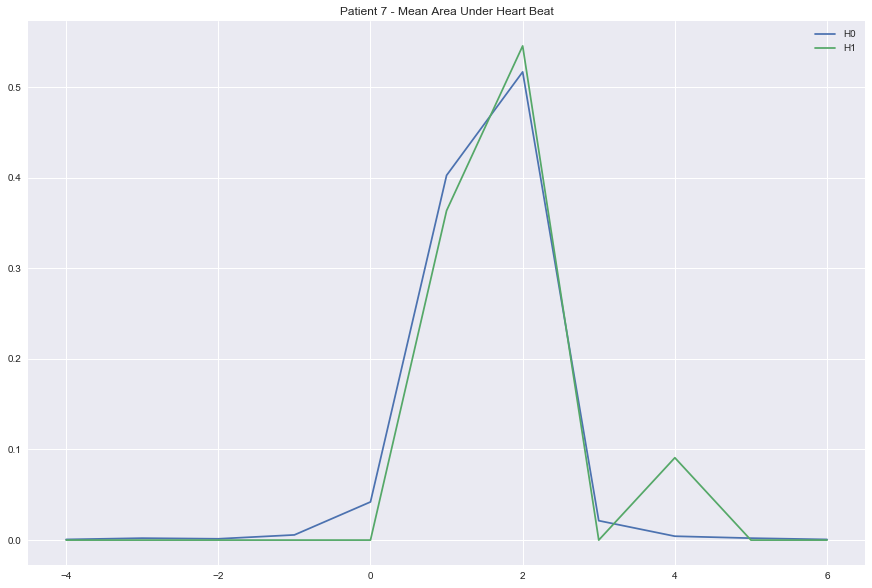

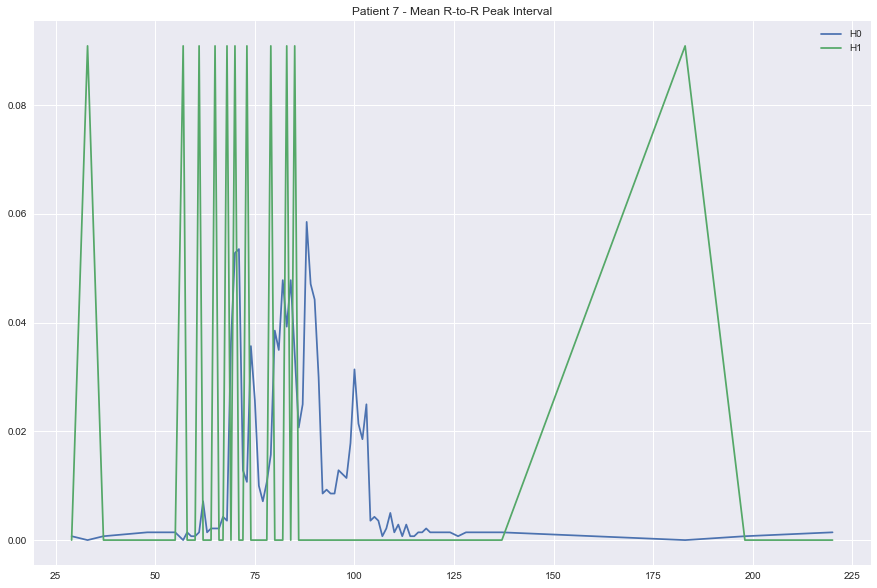

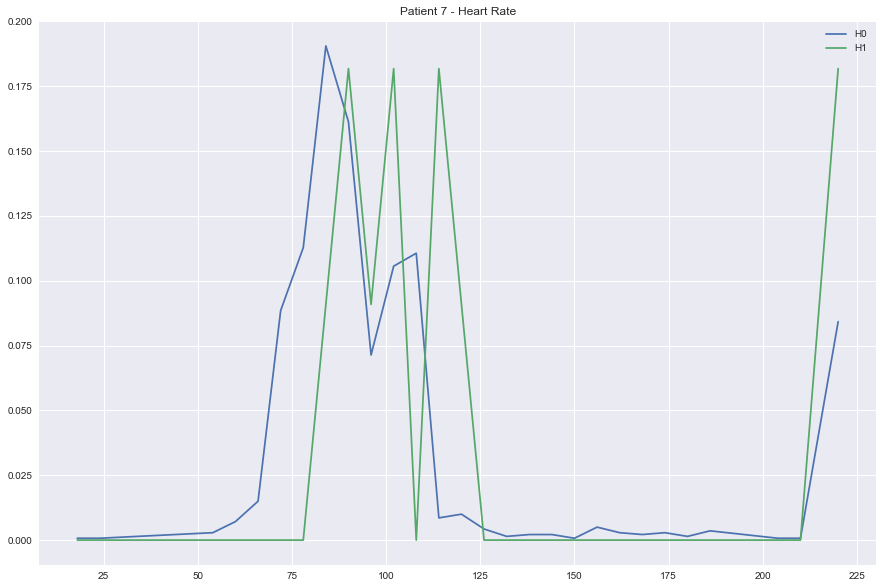

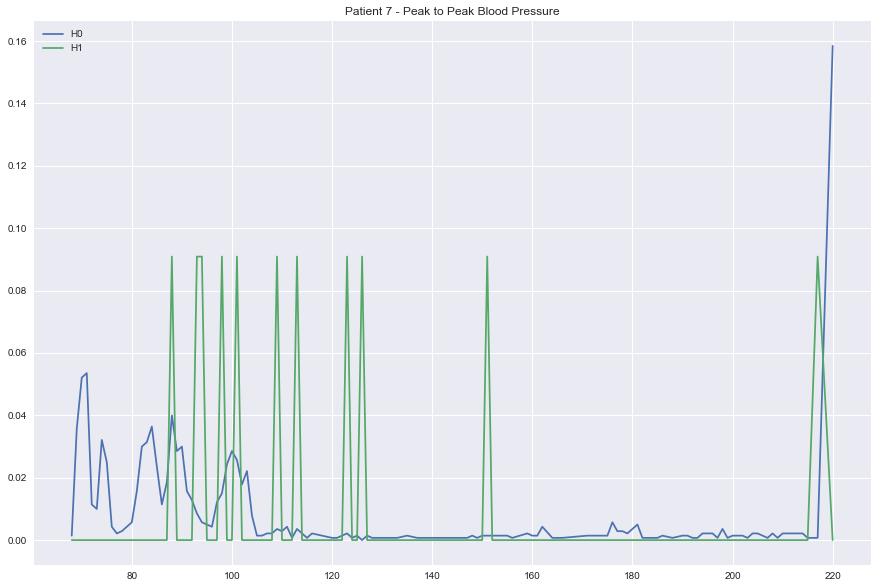

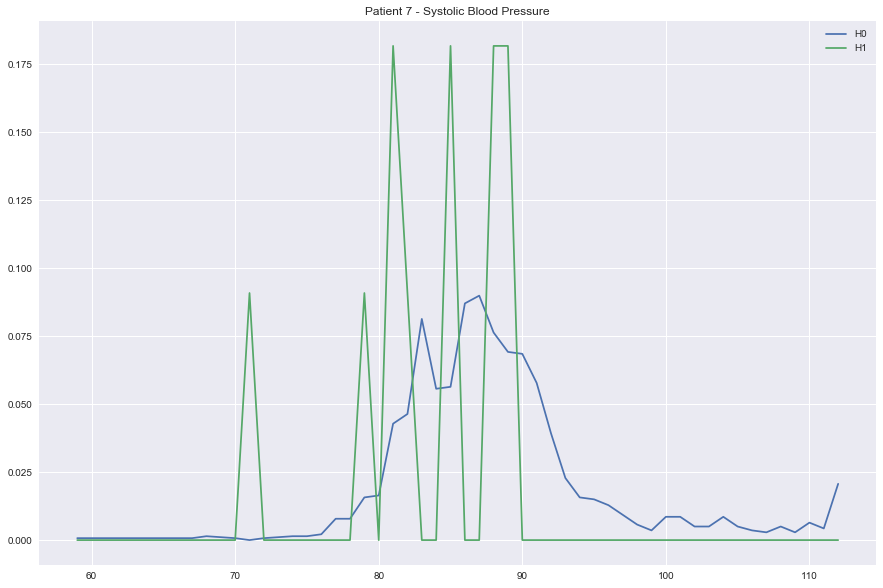

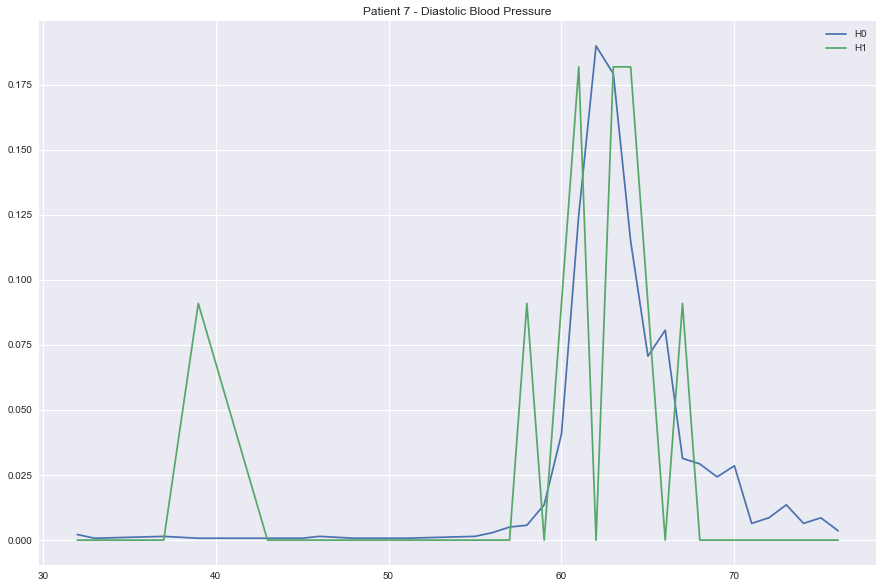

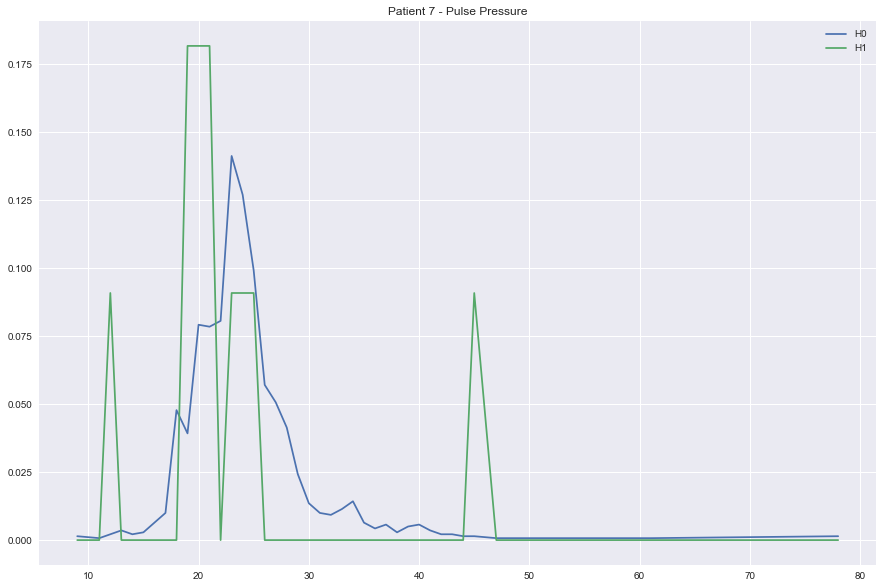

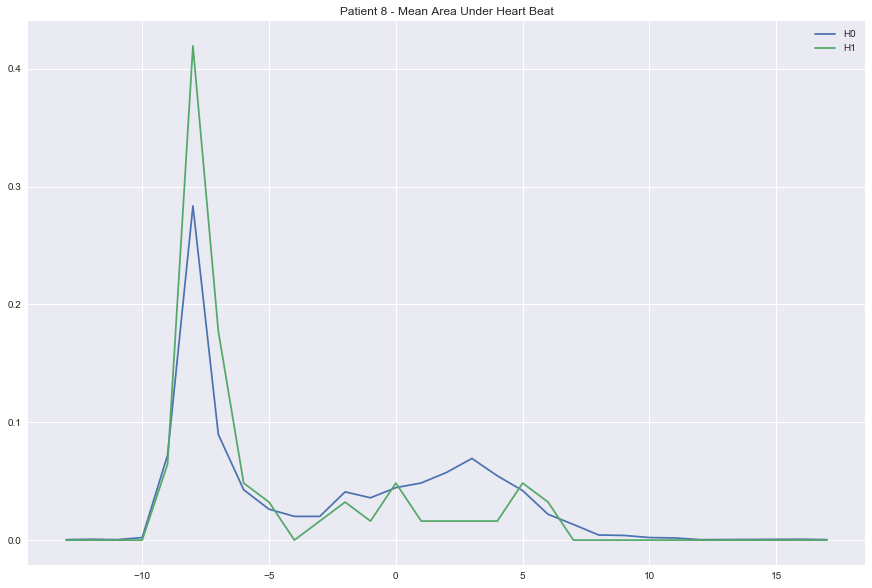

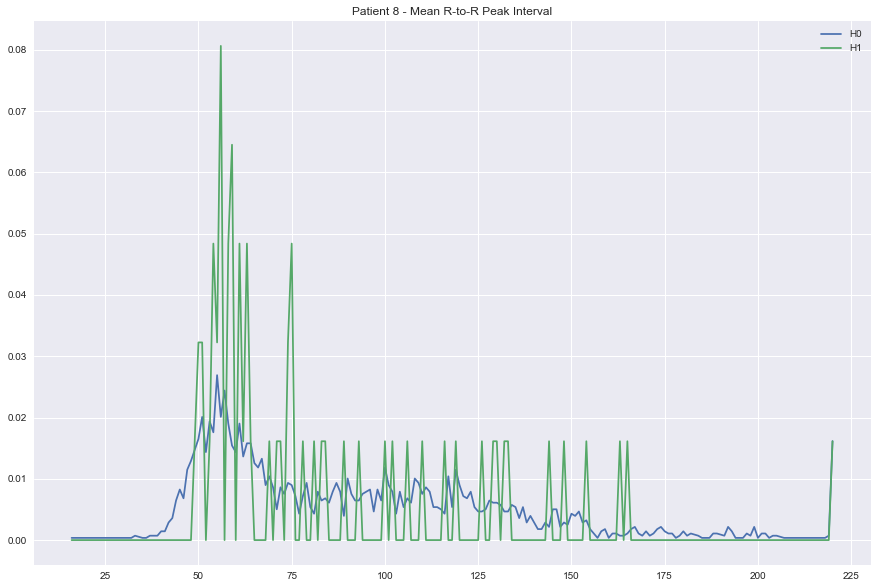

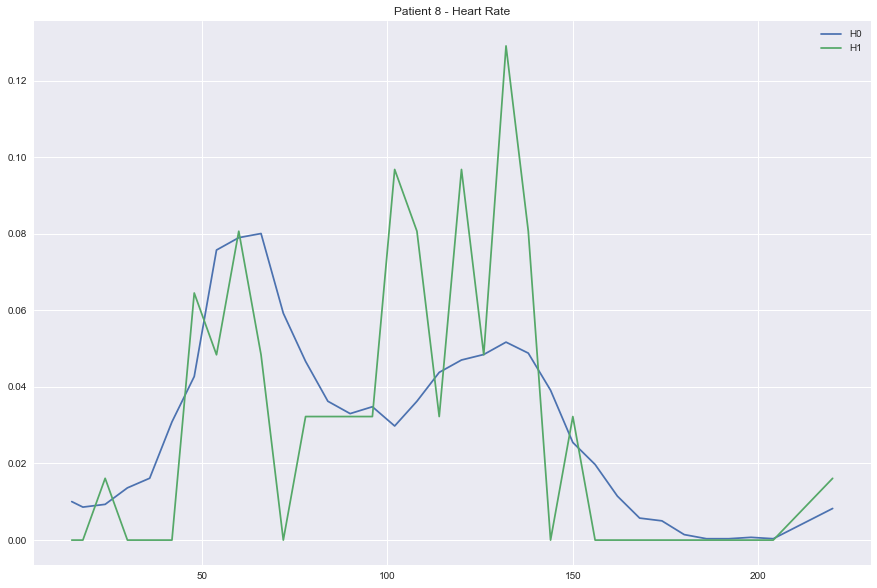

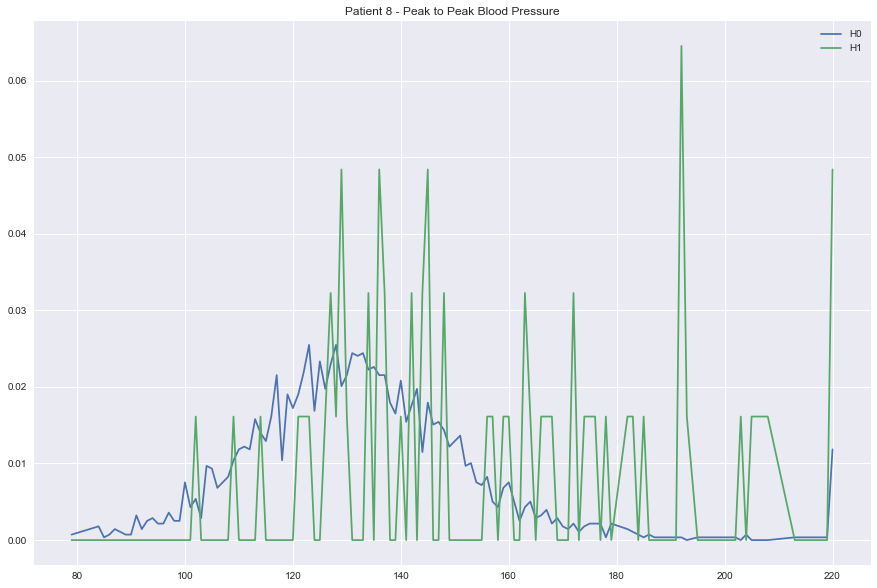

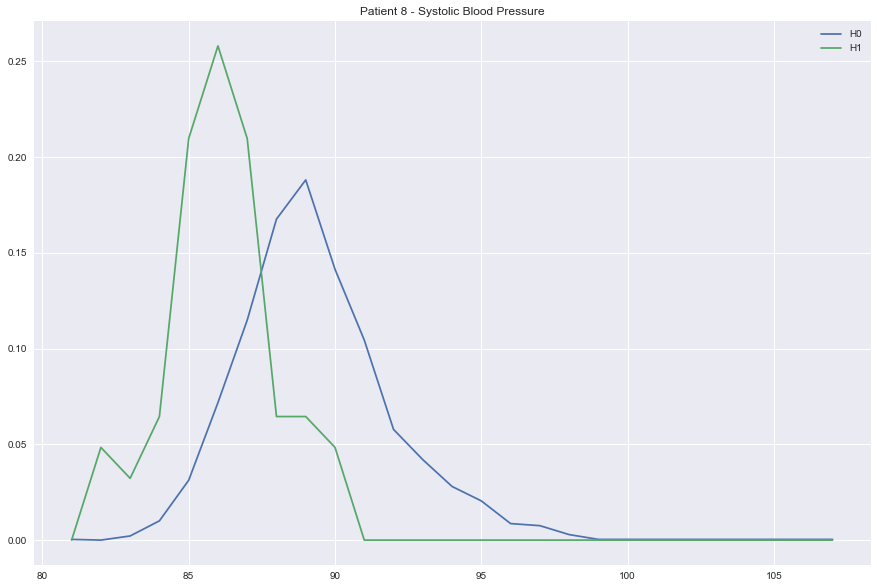

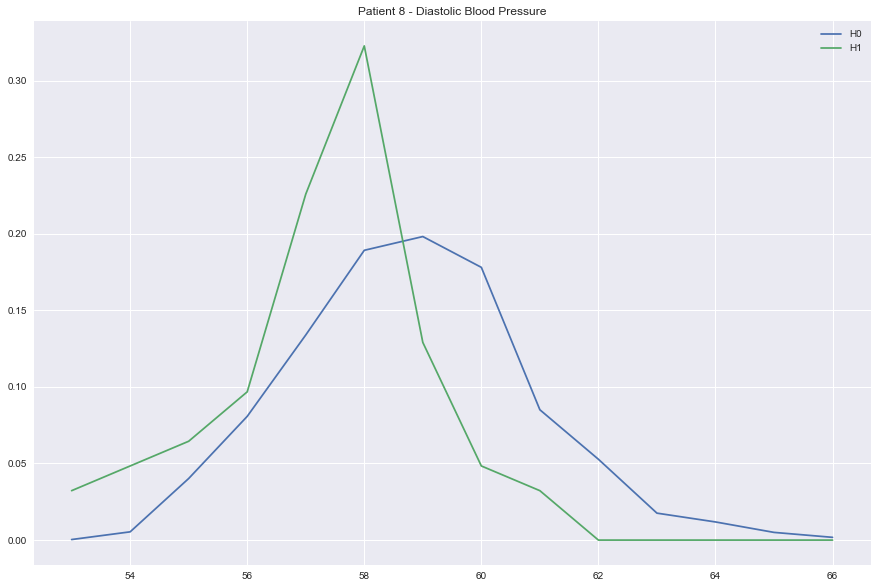

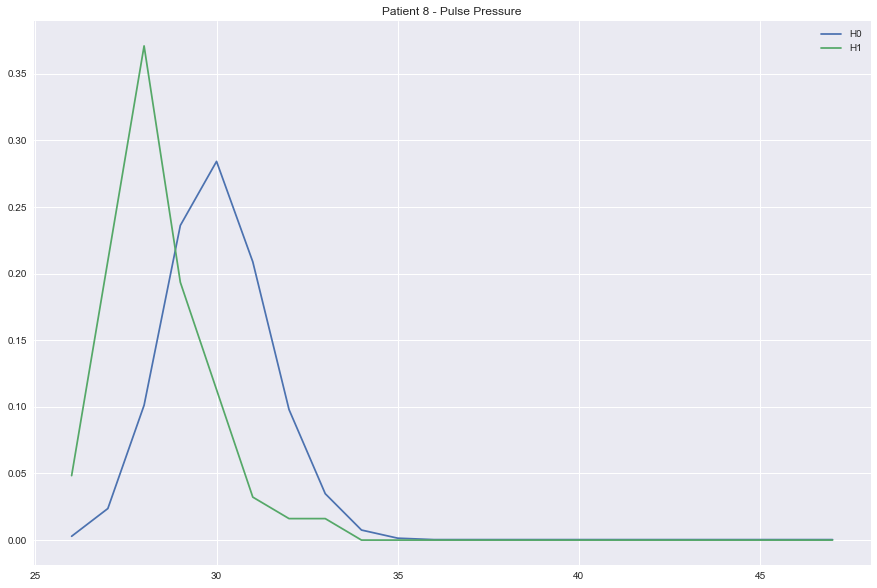

In [8]:
plt.show()

## Task 1.1d, 1.1e - Calculating ML & MAP Vectors

In [9]:
for patient_index, patient in enumerate(likelihood_matrix):
    for feature_index, feature in enumerate(patient):
        feature_h0 = feature[feature.columns[0]]
        feature_h1 = feature[feature.columns[1]]
        prior_h0 = prior_probabilities['PH0'].loc[patient_index]
        prior_h1 = prior_probabilities['PH1'].loc[patient_index]
        
        feature['ML']  = (feature_h1 >= feature_h0).astype(int)
        feature['MAP'] = (prior_h1 * feature_h1 >= prior_h0 * feature_h0).astype(int)
        if patient_index == 0:
            display(feature)

,Mean Area Under Heart Beat H0,Mean Area Under Heart Beat H1,ML,MAP
-8,0.001075,0.000000,0,0
-7,0.000717,0.000000,0,0
-6,0.020072,0.000000,0,0
-5,0.650538,0.000000,0,0
-4,0.135125,0.000000,0,0
-3,0.041219,0.000000,0,0
-2,0.036918,0.013158,0,0
-1,0.029391,0.026316,0,0
0,0.027240,0.026316,0,0
1,0.017921,0.092105,1,0


,Mean R-to-R Peak Interval H0,Mean R-to-R Peak Interval H1,ML,MAP
59,0.000000,0.013158,1,1
60,0.000358,0.000000,0,0
61,0.000717,0.013158,1,0
62,0.000000,0.013158,1,1
63,0.000000,0.013158,1,1
64,0.000000,0.026316,1,1
65,0.000358,0.013158,1,0
66,0.000358,0.000000,0,0
67,0.000000,0.013158,1,1
68,0.000000,0.026316,1,1


,Heart Rate H0,Heart Rate H1,ML,MAP
30,0.000717,0.000000,0,0
42,0.000717,0.000000,0,0
48,0.000358,0.000000,0,0
54,0.000717,0.000000,0,0
60,0.000358,0.000000,0,0
66,0.003943,0.013158,1,0
72,0.061649,0.052632,0,0
78,0.251971,0.052632,0,0
84,0.292473,0.078947,0,0
90,0.250538,0.171053,0,0


,Peak to Peak Blood Pressure H0,Peak to Peak Blood Pressure H1,ML,MAP
51,0.000358,0.000000,0,0
55,0.000000,0.013158,1,1
57,0.000000,0.013158,1,1
59,0.000000,0.013158,1,1
60,0.000358,0.000000,0,0
61,0.000358,0.000000,0,0
63,0.000000,0.013158,1,1
64,0.000358,0.013158,1,0
65,0.000358,0.000000,0,0
66,0.000000,0.026316,1,1


,Systolic Blood Pressure H0,Systolic Blood Pressure H1,ML,MAP
68,0.000358,0.000000,0,0
69,0.001075,0.000000,0,0
70,0.003226,0.000000,0,0
71,0.002509,0.000000,0,0
72,0.001434,0.000000,0,0
73,0.003584,0.013158,1,0
74,0.022222,0.052632,1,0
75,0.057348,0.092105,1,0
76,0.105735,0.131579,1,0
77,0.123297,0.184211,1,0


,Diastolic Blood Pressure H0,Diastolic Blood Pressure H1,ML,MAP
37,0.000358,0.000000,0,0
50,0.000358,0.000000,0,0
51,0.000358,0.000000,0,0
52,0.000358,0.000000,0,0
53,0.000717,0.000000,0,0
54,0.000717,0.000000,0,0
55,0.000717,0.000000,0,0
56,0.000717,0.000000,0,0
57,0.005376,0.000000,0,0
58,0.015412,0.013158,0,0


,Pulse Pressure H0,Pulse Pressure H1,ML,MAP
10,0.000358,0.000000,0,0
11,0.002867,0.000000,0,0
12,0.008244,0.013158,1,0
13,0.055556,0.052632,0,0
14,0.162366,0.171053,1,0
15,0.192832,0.302632,1,0
16,0.164516,0.184211,1,0
17,0.121864,0.144737,1,0
18,0.086022,0.039474,0,0
19,0.060573,0.039474,0,0


## Task 1.2a - Generating Alarms Using Test Data and Likelihood Matrix

In [10]:
def lookup_MAP(patient_index, feature_index, value):
    df = likelihood_matrix[patient_index][feature_index]['MAP']
    return df.loc[value] if value in df.index else 0
def lookup_ML(patient_index, feature_index, value):
    df = likelihood_matrix[patient_index][feature_index]['ML']
    return df.loc[value] if value in df.index else 0

In [11]:
generated_alarms = []
for patient_index, patient in enumerate(test_data):
    generated_alarms.append(pd.DataFrame())
    for feature_index, feature in enumerate(features):
        df = generated_alarms[patient_index]
        df[['%s ML'  % str(feature)]] = patient[[feature]].applymap(lambda row: lookup_ML(patient_index,feature_index, row))
        df[['%s MAP' % str(feature)]] = patient[[feature]].applymap(lambda row: lookup_MAP(patient_index,feature_index, row))
    df['Golden Alarms'] = patient['Golden Alarms']
    
display(generated_alarms[0])

,Mean Area Under Heart Beat ML,Mean Area Under Heart Beat MAP,Mean R-to-R Peak Interval ML,Mean R-to-R Peak Interval MAP,Heart Rate ML,Heart Rate MAP,Peak to Peak Blood Pressure ML,Peak to Peak Blood Pressure MAP,Systolic Blood Pressure ML,Systolic Blood Pressure MAP,Diastolic Blood Pressure ML,Diastolic Blood Pressure MAP,Pulse Pressure ML,Pulse Pressure MAP,Golden Alarms
2866,1,0,1,0,1,0,1,0,0,0,1,0,0,0,1
2867,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2868,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2869,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2870,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2871,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2872,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2873,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2874,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2875,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


## Task 1.2b - Generating Probability of Error, False Alarm, & Missed Detection

In [12]:
def get_cond_prob_matrix(patient_index):
    missed_detection_ml = []
    length = len(generated_alarms[patient_index].columns)-1
    for i in range(0, length, 2):
        df = generated_alarms[patient_index]
        df = df[df['Golden Alarms'] == 1]
        golden = len(df)
        col = [df.columns[i]]
        df = df[col]
        df = df[df[col] == 0].dropna()
        missed_detection_ml.append(len(df)/golden)

    missed_detection_map = []
    for i in range(1, length, 2):
        df = generated_alarms[patient_index]
        df = df[df['Golden Alarms'] == 1]
        golden = len(df)
        col = [df.columns[i]]
        df = df[col]
        df = df[df[col] == 0].dropna()
        missed_detection_map.append(len(df)/golden)

    false_alarm_ml = []
    for i in range(0, length, 2):
        df = generated_alarms[patient_index]
        df = df[df['Golden Alarms'] == 0]
        golden = len(df)
        col = [df.columns[i]]
        df = df[col]
        df = df[df[col] == 1].dropna()
        false_alarm_ml.append(len(df)/golden)

    false_alarm_map = []
    for i in range(1, length, 2):
        df = generated_alarms[patient_index]
        df = df[df['Golden Alarms'] == 0]
        golden = len(df)
        col = [df.columns[i]]
        df = df[col]
        df = df[df[col] == 1].dropna()
        false_alarm_map.append(len(df)/golden)  

    conditional_probability_matrix = pd.DataFrame([missed_detection_ml, missed_detection_map, \
                                                   false_alarm_ml, false_alarm_map]).T
    conditional_probability_matrix.columns = ['Missed Detection ML', 'Missed Detection MAP', \
                                              'False Alarm ML', 'False Alarm MAP']
    conditional_probability_matrix.index = features

    ph0 = prior_probabilities.loc[0][0]
    ph1 = prior_probabilities.loc[0][1]

    conditional_probability_matrix['P(Error) ML']  = 0.5 * conditional_probability_matrix['False Alarm ML'] + \
                                                     0.5 * conditional_probability_matrix['Missed Detection ML']
    conditional_probability_matrix['P(Error) MAP'] = ph0 * conditional_probability_matrix['False Alarm MAP'] + \
                                                     ph1 * conditional_probability_matrix['Missed Detection MAP']
    
    return conditional_probability_matrix




In [13]:
conditional_probability_matrix = []
for patient_index, patient in enumerate(test_data):
    conditional_probability_matrix.append(get_cond_prob_matrix(patient_index))
    display(conditional_probability_matrix[patient_index])

,Missed Detection ML,Missed Detection MAP,False Alarm ML,False Alarm MAP,P(Error) ML,P(Error) MAP
Mean Area Under Heart Beat,0.068966,0.827586,0.034188,0.002849,0.051577,0.024719
Mean R-to-R Peak Interval,0.551724,1.000000,0.075499,0.000000,0.313611,0.026518
Heart Rate,0.586207,0.931034,0.042735,0.000000,0.314471,0.024689
Peak to Peak Blood Pressure,0.551724,0.931034,0.075499,0.000000,0.313611,0.024689
Systolic Blood Pressure,0.931034,1.000000,0.059117,0.000000,0.495076,0.026518
Diastolic Blood Pressure,0.689655,1.000000,0.383191,0.000000,0.536423,0.026518
Pulse Pressure,0.517241,1.000000,0.205128,0.000000,0.361185,0.026518


,Missed Detection ML,Missed Detection MAP,False Alarm ML,False Alarm MAP,P(Error) ML,P(Error) MAP
Mean Area Under Heart Beat,0.0,1.0,0.987170,0.000000,0.493585,0.026518
Mean R-to-R Peak Interval,0.8,1.0,0.168924,0.000000,0.484462,0.026518
Heart Rate,0.6,1.0,0.090520,0.000000,0.345260,0.026518
Peak to Peak Blood Pressure,1.0,1.0,0.053457,0.001426,0.526728,0.027906
Systolic Blood Pressure,0.6,1.0,0.285103,0.000000,0.442552,0.026518
Diastolic Blood Pressure,1.0,1.0,0.044904,0.000000,0.522452,0.026518
Pulse Pressure,0.8,1.0,0.188881,0.000000,0.494440,0.026518


,Missed Detection ML,Missed Detection MAP,False Alarm ML,False Alarm MAP,P(Error) ML,P(Error) MAP
Mean Area Under Heart Beat,1.0,1.0,0.002797,0.0,0.501399,0.026518
Mean R-to-R Peak Interval,1.0,1.0,0.002098,0.0,0.501049,0.026518
Heart Rate,1.0,1.0,0.017483,0.0,0.508741,0.026518
Peak to Peak Blood Pressure,1.0,1.0,0.002098,0.0,0.501049,0.026518
Systolic Blood Pressure,1.0,1.0,0.018182,0.0,0.509091,0.026518
Diastolic Blood Pressure,0.5,1.0,0.023776,0.0,0.261888,0.026518
Pulse Pressure,1.0,1.0,0.374825,0.0,0.687413,0.026518


,Missed Detection ML,Missed Detection MAP,False Alarm ML,False Alarm MAP,P(Error) ML,P(Error) MAP
Mean Area Under Heart Beat,0.000000,1.0,0.991009,0.000000,0.495504,0.026518
Mean R-to-R Peak Interval,1.000000,1.0,0.013986,0.000999,0.506993,0.027490
Heart Rate,0.666667,1.0,0.064935,0.000000,0.365801,0.026518
Peak to Peak Blood Pressure,0.666667,1.0,0.000999,0.000000,0.333833,0.026518
Systolic Blood Pressure,1.000000,1.0,0.031968,0.000000,0.515984,0.026518
Diastolic Blood Pressure,1.000000,1.0,0.232767,0.000000,0.616384,0.026518
Pulse Pressure,1.000000,1.0,0.009990,0.000000,0.504995,0.026518


,Missed Detection ML,Missed Detection MAP,False Alarm ML,False Alarm MAP,P(Error) ML,P(Error) MAP
Mean Area Under Heart Beat,0.666667,1.0,0.064990,0.000000,0.365828,0.026518
Mean R-to-R Peak Interval,1.000000,1.0,0.071279,0.000000,0.535639,0.026518
Heart Rate,0.666667,1.0,0.317261,0.000000,0.491964,0.026518
Peak to Peak Blood Pressure,1.000000,1.0,0.053110,0.000699,0.526555,0.027198
Systolic Blood Pressure,1.000000,1.0,0.070580,0.000000,0.535290,0.026518
Diastolic Blood Pressure,0.666667,1.0,0.122991,0.000000,0.394829,0.026518
Pulse Pressure,1.000000,1.0,0.265549,0.000000,0.632774,0.026518


,Missed Detection ML,Missed Detection MAP,False Alarm ML,False Alarm MAP,P(Error) ML,P(Error) MAP
Mean Area Under Heart Beat,0.578947,1.000000,0.613087,0.000000,0.596017,0.026518
Mean R-to-R Peak Interval,0.736842,1.000000,0.372688,0.000000,0.554765,0.026518
Heart Rate,0.684211,1.000000,0.375533,0.000000,0.529872,0.026518
Peak to Peak Blood Pressure,0.684211,1.000000,0.204125,0.000711,0.444168,0.027210
Systolic Blood Pressure,0.473684,0.842105,0.239687,0.006401,0.356686,0.028562
Diastolic Blood Pressure,0.157895,1.000000,0.217639,0.000000,0.187767,0.026518
Pulse Pressure,0.684211,1.000000,0.337127,0.000000,0.510669,0.026518


,Missed Detection ML,Missed Detection MAP,False Alarm ML,False Alarm MAP,P(Error) ML,P(Error) MAP
Mean Area Under Heart Beat,0.655172,1.000000,0.428775,0.000000,0.541974,0.026518
Mean R-to-R Peak Interval,0.827586,1.000000,0.333333,0.000000,0.580460,0.026518
Heart Rate,0.724138,1.000000,0.262821,0.000000,0.493479,0.026518
Peak to Peak Blood Pressure,0.655172,0.965517,0.258547,0.001425,0.456860,0.026990
Systolic Blood Pressure,0.517241,1.000000,0.084758,0.000000,0.301000,0.026518
Diastolic Blood Pressure,0.586207,1.000000,0.150997,0.000000,0.368602,0.026518
Pulse Pressure,0.379310,1.000000,0.279202,0.000000,0.329256,0.026518


,Missed Detection ML,Missed Detection MAP,False Alarm ML,False Alarm MAP,P(Error) ML,P(Error) MAP
Mean Area Under Heart Beat,0.416667,1.000000,0.848703,0.000000,0.632685,0.026518
Mean R-to-R Peak Interval,0.583333,1.000000,0.023055,0.000000,0.303194,0.026518
Heart Rate,0.666667,1.000000,0.070605,0.000000,0.368636,0.026518
Peak to Peak Blood Pressure,0.833333,0.916667,0.193084,0.002882,0.513208,0.027113
Systolic Blood Pressure,0.666667,1.000000,0.393372,0.001441,0.530019,0.027921
Diastolic Blood Pressure,0.250000,1.000000,0.638329,0.000000,0.444164,0.026518
Pulse Pressure,0.666667,1.000000,0.410663,0.000000,0.538665,0.026518


,Missed Detection ML,Missed Detection MAP,False Alarm ML,False Alarm MAP,P(Error) ML,P(Error) MAP
Mean Area Under Heart Beat,0.578947,1.000000,0.613087,0.000000,0.596017,0.026518
Mean R-to-R Peak Interval,0.736842,1.000000,0.372688,0.000000,0.554765,0.026518
Heart Rate,0.684211,1.000000,0.375533,0.000000,0.529872,0.026518
Peak to Peak Blood Pressure,0.684211,1.000000,0.204125,0.000711,0.444168,0.027210
Systolic Blood Pressure,0.473684,0.842105,0.239687,0.006401,0.356686,0.028562
Diastolic Blood Pressure,0.157895,1.000000,0.217639,0.000000,0.187767,0.026518
Pulse Pressure,0.684211,1.000000,0.337127,0.000000,0.510669,0.026518


## Task 2.1a - Correlate Coefficients of Heart Rate Across Patients

In [14]:
corrcoef = []
for i in range(9):
    temp = []
    for j in range(9):
        a = patient_data[i]['Heart Rate']
        b = patient_data[j]['Heart Rate']
        length = min(len(a), len(b))
        temp.append(abs(np.corrcoef(np.asarray(a[:length]), np.asarray(b[:length]))[0][1]))
    corrcoef.append(temp)
df = pd.DataFrame(corrcoef)
df

,0,1,2,3,4,5,6,7,8
0,1.000000,0.083897,0.188648,0.046239,0.035651,0.146867,0.167403,0.151857,0.146867
1,0.083897,1.000000,0.415132,0.067249,0.110244,0.010139,0.343511,0.142679,0.010139
2,0.188648,0.415132,1.000000,0.051025,0.212478,0.031632,0.583610,0.270494,0.031632
3,0.046239,0.067249,0.051025,1.000000,0.070834,0.100789,0.028850,0.138294,0.100789
4,0.035651,0.110244,0.212478,0.070834,1.000000,0.094013,0.096442,0.193773,0.094013
5,0.146867,0.010139,0.031632,0.100789,0.094013,1.000000,0.072926,0.313802,1.000000
6,0.167403,0.343511,0.583610,0.028850,0.096442,0.072926,1.000000,0.220698,0.072926
7,0.151857,0.142679,0.270494,0.138294,0.193773,0.313802,0.220698,1.000000,0.313802
8,0.146867,0.010139,0.031632,0.100789,0.094013,1.000000,0.072926,0.313802,1.000000


We can see that patient 5 and patient 8 have perfect correlation. That means that these patient's data is exactly the same.

High correlation means that two two pieces of data are very related.

## Task 2.2 - Method 1, Finding Lowest Probability of Error

In [15]:
minimum_perror = []

print('------------2 Features with Minimum P(Error) ML Per Patient------------')

for df in conditional_probability_matrix:
    df = df.sort_values(['P(Error) ML']).iloc[[0,1]]
    minimum_perror.append(df['P(Error) ML'].sum())
    display(df)

min_perr = pd.DataFrame(minimum_perror, columns=['P(Error) ML Min Sum'])
min_perr = min_perr.sort_values(['P(Error) ML Min Sum'])

print('------------2 Features with Minimum P(Error) MAP Per Patient------------')

minimum_perror = []
for df in conditional_probability_matrix:
    df = df.sort_values(['P(Error) MAP']).iloc[[0,1]]
    minimum_perror.append(df['P(Error) MAP'].sum())
    display(df)

display(min_perr)

min_perr = pd.DataFrame(minimum_perror, columns=['P(Error) MAP Min Sum'])
min_perr = min_perr.sort_values(['P(Error) MAP Min Sum'])
display(min_perr)

------------2 Features with Minimum P(Error) ML Per Patient------------


,Missed Detection ML,Missed Detection MAP,False Alarm ML,False Alarm MAP,P(Error) ML,P(Error) MAP
Mean Area Under Heart Beat,0.068966,0.827586,0.034188,0.002849,0.051577,0.024719
Mean R-to-R Peak Interval,0.551724,1.000000,0.075499,0.000000,0.313611,0.026518


,Missed Detection ML,Missed Detection MAP,False Alarm ML,False Alarm MAP,P(Error) ML,P(Error) MAP
Heart Rate,0.6,1.0,0.090520,0.0,0.345260,0.026518
Systolic Blood Pressure,0.6,1.0,0.285103,0.0,0.442552,0.026518


,Missed Detection ML,Missed Detection MAP,False Alarm ML,False Alarm MAP,P(Error) ML,P(Error) MAP
Diastolic Blood Pressure,0.5,1.0,0.023776,0.0,0.261888,0.026518
Mean R-to-R Peak Interval,1.0,1.0,0.002098,0.0,0.501049,0.026518


,Missed Detection ML,Missed Detection MAP,False Alarm ML,False Alarm MAP,P(Error) ML,P(Error) MAP
Peak to Peak Blood Pressure,0.666667,1.0,0.000999,0.0,0.333833,0.026518
Heart Rate,0.666667,1.0,0.064935,0.0,0.365801,0.026518


,Missed Detection ML,Missed Detection MAP,False Alarm ML,False Alarm MAP,P(Error) ML,P(Error) MAP
Mean Area Under Heart Beat,0.666667,1.0,0.064990,0.0,0.365828,0.026518
Diastolic Blood Pressure,0.666667,1.0,0.122991,0.0,0.394829,0.026518


,Missed Detection ML,Missed Detection MAP,False Alarm ML,False Alarm MAP,P(Error) ML,P(Error) MAP
Diastolic Blood Pressure,0.157895,1.000000,0.217639,0.000000,0.187767,0.026518
Systolic Blood Pressure,0.473684,0.842105,0.239687,0.006401,0.356686,0.028562


,Missed Detection ML,Missed Detection MAP,False Alarm ML,False Alarm MAP,P(Error) ML,P(Error) MAP
Systolic Blood Pressure,0.517241,1.0,0.084758,0.0,0.301000,0.026518
Pulse Pressure,0.379310,1.0,0.279202,0.0,0.329256,0.026518


,Missed Detection ML,Missed Detection MAP,False Alarm ML,False Alarm MAP,P(Error) ML,P(Error) MAP
Mean R-to-R Peak Interval,0.583333,1.0,0.023055,0.0,0.303194,0.026518
Heart Rate,0.666667,1.0,0.070605,0.0,0.368636,0.026518


,Missed Detection ML,Missed Detection MAP,False Alarm ML,False Alarm MAP,P(Error) ML,P(Error) MAP
Diastolic Blood Pressure,0.157895,1.000000,0.217639,0.000000,0.187767,0.026518
Systolic Blood Pressure,0.473684,0.842105,0.239687,0.006401,0.356686,0.028562


------------2 Features with Minimum P(Error) MAP Per Patient------------


,Missed Detection ML,Missed Detection MAP,False Alarm ML,False Alarm MAP,P(Error) ML,P(Error) MAP
Heart Rate,0.586207,0.931034,0.042735,0.0,0.314471,0.024689
Peak to Peak Blood Pressure,0.551724,0.931034,0.075499,0.0,0.313611,0.024689


,Missed Detection ML,Missed Detection MAP,False Alarm ML,False Alarm MAP,P(Error) ML,P(Error) MAP
Mean Area Under Heart Beat,0.0,1.0,0.987170,0.0,0.493585,0.026518
Mean R-to-R Peak Interval,0.8,1.0,0.168924,0.0,0.484462,0.026518


,Missed Detection ML,Missed Detection MAP,False Alarm ML,False Alarm MAP,P(Error) ML,P(Error) MAP
Mean Area Under Heart Beat,1.0,1.0,0.002797,0.0,0.501399,0.026518
Mean R-to-R Peak Interval,1.0,1.0,0.002098,0.0,0.501049,0.026518


,Missed Detection ML,Missed Detection MAP,False Alarm ML,False Alarm MAP,P(Error) ML,P(Error) MAP
Mean Area Under Heart Beat,0.000000,1.0,0.991009,0.0,0.495504,0.026518
Heart Rate,0.666667,1.0,0.064935,0.0,0.365801,0.026518


,Missed Detection ML,Missed Detection MAP,False Alarm ML,False Alarm MAP,P(Error) ML,P(Error) MAP
Mean Area Under Heart Beat,0.666667,1.0,0.064990,0.0,0.365828,0.026518
Mean R-to-R Peak Interval,1.000000,1.0,0.071279,0.0,0.535639,0.026518


,Missed Detection ML,Missed Detection MAP,False Alarm ML,False Alarm MAP,P(Error) ML,P(Error) MAP
Mean Area Under Heart Beat,0.578947,1.0,0.613087,0.0,0.596017,0.026518
Mean R-to-R Peak Interval,0.736842,1.0,0.372688,0.0,0.554765,0.026518


,Missed Detection ML,Missed Detection MAP,False Alarm ML,False Alarm MAP,P(Error) ML,P(Error) MAP
Mean Area Under Heart Beat,0.655172,1.0,0.428775,0.0,0.541974,0.026518
Mean R-to-R Peak Interval,0.827586,1.0,0.333333,0.0,0.580460,0.026518


,Missed Detection ML,Missed Detection MAP,False Alarm ML,False Alarm MAP,P(Error) ML,P(Error) MAP
Mean Area Under Heart Beat,0.416667,1.0,0.848703,0.0,0.632685,0.026518
Mean R-to-R Peak Interval,0.583333,1.0,0.023055,0.0,0.303194,0.026518


,Missed Detection ML,Missed Detection MAP,False Alarm ML,False Alarm MAP,P(Error) ML,P(Error) MAP
Mean Area Under Heart Beat,0.578947,1.0,0.613087,0.0,0.596017,0.026518
Mean R-to-R Peak Interval,0.736842,1.0,0.372688,0.0,0.554765,0.026518


,P(Error) ML Min Sum
0,0.365188
5,0.544452
8,0.544452
6,0.630256
7,0.671830
3,0.699634
4,0.760657
2,0.762937
1,0.787812


,P(Error) MAP Min Sum
0,0.049378
1,0.053036
2,0.053036
3,0.053036
4,0.053036
5,0.053036
6,0.053036
7,0.053036
8,0.053036


Method 1)

Using the ML rule, we would use patients 0, 5, 8 as our choices. Their corresponding pairs of features that provide the lowest error are:
<ol>
<l> 0: {"Mean Area Under Heart Beat", "Heart Rate"}
<l> 5: {"Mean Area Under Heart Beat", "Mean R-to-R Peak Interval"}
<l> 6: {"Peak to Peak Blood Pressure", "Heart Rate"}

We skipped Patient 8 since their data is the exact same as Patient 5

Looking at the MAP rule, since all features provide nearly the same error it does not matter which pairs of features we choose.

## Task 2.2 - Method 3, Correlation Between Features

In [16]:
# Go through each patient and compare their pair of feature coefficient
sum_corrcoef = []
for patient in patient_data:
    corrcoef = []
    for feature1 in features:
        temp = []
        for feature2 in features:
            a = patient[feature1]
            b = patient[feature2]
            length = min(len(a), len(b))
            temp.append(abs(np.corrcoef(np.asarray(a[:length]), np.asarray(b[:length]))[0][1]))
        corrcoef.append(temp)
        
    df = pd.DataFrame(corrcoef)
    df.columns = features
    df.index = features
    
    display(df)

,Mean Area Under Heart Beat,Mean R-to-R Peak Interval,Heart Rate,Peak to Peak Blood Pressure,Systolic Blood Pressure,Diastolic Blood Pressure,Pulse Pressure
Mean Area Under Heart Beat,1.000000,0.315048,0.282044,0.226446,0.107965,0.024806,0.113643
Mean R-to-R Peak Interval,0.315048,1.000000,0.804726,0.561284,0.172430,0.143498,0.295156
Heart Rate,0.282044,0.804726,1.000000,0.476743,0.159752,0.121443,0.265736
Peak to Peak Blood Pressure,0.226446,0.561284,0.476743,1.000000,0.290605,0.219339,0.480990
Systolic Blood Pressure,0.107965,0.172430,0.159752,0.290605,1.000000,0.534694,0.848593
Diastolic Blood Pressure,0.024806,0.143498,0.121443,0.219339,0.534694,1.000000,0.022784
Pulse Pressure,0.113643,0.295156,0.265736,0.480990,0.848593,0.022784,1.000000


,Mean Area Under Heart Beat,Mean R-to-R Peak Interval,Heart Rate,Peak to Peak Blood Pressure,Systolic Blood Pressure,Diastolic Blood Pressure,Pulse Pressure
Mean Area Under Heart Beat,1.000000,0.499053,0.420970,0.168729,0.166002,0.071358,0.140917
Mean R-to-R Peak Interval,0.499053,1.000000,0.792553,0.408618,0.010993,0.425492,0.139418
Heart Rate,0.420970,0.792553,1.000000,0.159685,0.027883,0.271842,0.123528
Peak to Peak Blood Pressure,0.168729,0.408618,0.159685,1.000000,0.194720,0.426695,0.350404
Systolic Blood Pressure,0.166002,0.010993,0.027883,0.194720,1.000000,0.197383,0.934654
Diastolic Blood Pressure,0.071358,0.425492,0.271842,0.426695,0.197383,1.000000,0.151708
Pulse Pressure,0.140917,0.139418,0.123528,0.350404,0.934654,0.151708,1.000000


,Mean Area Under Heart Beat,Mean R-to-R Peak Interval,Heart Rate,Peak to Peak Blood Pressure,Systolic Blood Pressure,Diastolic Blood Pressure,Pulse Pressure
Mean Area Under Heart Beat,1.000000,0.288218,0.309608,0.306603,0.338710,0.314172,0.331914
Mean R-to-R Peak Interval,0.288218,1.000000,0.962443,0.785880,0.424297,0.427998,0.383624
Heart Rate,0.309608,0.962443,1.000000,0.745969,0.439884,0.449887,0.392019
Peak to Peak Blood Pressure,0.306603,0.785880,0.745969,1.000000,0.385049,0.486721,0.253459
Systolic Blood Pressure,0.338710,0.424297,0.439884,0.385049,1.000000,0.950003,0.953993
Diastolic Blood Pressure,0.314172,0.427998,0.449887,0.486721,0.950003,1.000000,0.817643
Pulse Pressure,0.331914,0.383624,0.392019,0.253459,0.953993,0.817643,1.000000


,Mean Area Under Heart Beat,Mean R-to-R Peak Interval,Heart Rate,Peak to Peak Blood Pressure,Systolic Blood Pressure,Diastolic Blood Pressure,Pulse Pressure
Mean Area Under Heart Beat,1.000000,0.230739,0.142438,0.308936,0.119090,0.155408,0.220340
Mean R-to-R Peak Interval,0.230739,1.000000,0.314174,0.409013,0.191364,0.217867,0.047113
Heart Rate,0.142438,0.314174,1.000000,0.605269,0.002720,0.348164,0.231515
Peak to Peak Blood Pressure,0.308936,0.409013,0.605269,1.000000,0.095359,0.218592,0.241947
Systolic Blood Pressure,0.119090,0.191364,0.002720,0.095359,1.000000,0.312266,0.780963
Diastolic Blood Pressure,0.155408,0.217867,0.348164,0.218592,0.312266,1.000000,0.339649
Pulse Pressure,0.220340,0.047113,0.231515,0.241947,0.780963,0.339649,1.000000


,Mean Area Under Heart Beat,Mean R-to-R Peak Interval,Heart Rate,Peak to Peak Blood Pressure,Systolic Blood Pressure,Diastolic Blood Pressure,Pulse Pressure
Mean Area Under Heart Beat,1.000000,0.193632,0.171585,0.057565,0.058252,0.015911,0.127632
Mean R-to-R Peak Interval,0.193632,1.000000,0.881191,0.112546,0.554764,0.497290,0.538603
Heart Rate,0.171585,0.881191,1.000000,0.018538,0.511693,0.449883,0.503481
Peak to Peak Blood Pressure,0.057565,0.112546,0.018538,1.000000,0.334995,0.482611,0.138630
Systolic Blood Pressure,0.058252,0.554764,0.511693,0.334995,1.000000,0.932254,0.927375
Diastolic Blood Pressure,0.015911,0.497290,0.449883,0.482611,0.932254,1.000000,0.739517
Pulse Pressure,0.127632,0.538603,0.503481,0.138630,0.927375,0.739517,1.000000


,Mean Area Under Heart Beat,Mean R-to-R Peak Interval,Heart Rate,Peak to Peak Blood Pressure,Systolic Blood Pressure,Diastolic Blood Pressure,Pulse Pressure
Mean Area Under Heart Beat,1.000000,0.692761,0.726668,0.083331,0.078092,0.265169,0.456101
Mean R-to-R Peak Interval,0.692761,1.000000,0.842136,0.070246,0.102714,0.145726,0.354293
Heart Rate,0.726668,0.842136,1.000000,0.138871,0.098750,0.125938,0.321389
Peak to Peak Blood Pressure,0.083331,0.070246,0.138871,1.000000,0.473154,0.621188,0.022998
Systolic Blood Pressure,0.078092,0.102714,0.098750,0.473154,1.000000,0.798345,0.674208
Diastolic Blood Pressure,0.265169,0.145726,0.125938,0.621188,0.798345,1.000000,0.129228
Pulse Pressure,0.456101,0.354293,0.321389,0.022998,0.674208,0.129228,1.000000


,Mean Area Under Heart Beat,Mean R-to-R Peak Interval,Heart Rate,Peak to Peak Blood Pressure,Systolic Blood Pressure,Diastolic Blood Pressure,Pulse Pressure
Mean Area Under Heart Beat,1.000000,0.670962,0.748410,0.107181,0.015866,0.318313,0.457258
Mean R-to-R Peak Interval,0.670962,1.000000,0.838706,0.055578,0.037342,0.197167,0.326693
Heart Rate,0.748410,0.838706,1.000000,0.101848,0.063381,0.182347,0.356107
Peak to Peak Blood Pressure,0.107181,0.055578,0.101848,1.000000,0.554180,0.612958,0.130243
Systolic Blood Pressure,0.015866,0.037342,0.063381,0.554180,1.000000,0.816533,0.621975
Diastolic Blood Pressure,0.318313,0.197167,0.182347,0.612958,0.816533,1.000000,0.097676
Pulse Pressure,0.457258,0.326693,0.356107,0.130243,0.621975,0.097676,1.000000


,Mean Area Under Heart Beat,Mean R-to-R Peak Interval,Heart Rate,Peak to Peak Blood Pressure,Systolic Blood Pressure,Diastolic Blood Pressure,Pulse Pressure
Mean Area Under Heart Beat,1.000000,0.268943,0.178425,0.054178,0.036867,0.016442,0.063886
Mean R-to-R Peak Interval,0.268943,1.000000,0.415567,0.197813,0.263915,0.212420,0.202311
Heart Rate,0.178425,0.415567,1.000000,0.474554,0.129947,0.131670,0.270836
Peak to Peak Blood Pressure,0.054178,0.197813,0.474554,1.000000,0.158383,0.171799,0.336628
Systolic Blood Pressure,0.036867,0.263915,0.129947,0.158383,1.000000,0.688044,0.850508
Diastolic Blood Pressure,0.016442,0.212420,0.131670,0.171799,0.688044,1.000000,0.209976
Pulse Pressure,0.063886,0.202311,0.270836,0.336628,0.850508,0.209976,1.000000


,Mean Area Under Heart Beat,Mean R-to-R Peak Interval,Heart Rate,Peak to Peak Blood Pressure,Systolic Blood Pressure,Diastolic Blood Pressure,Pulse Pressure
Mean Area Under Heart Beat,1.000000,0.692761,0.726668,0.083331,0.078092,0.265169,0.456101
Mean R-to-R Peak Interval,0.692761,1.000000,0.842136,0.070246,0.102714,0.145726,0.354293
Heart Rate,0.726668,0.842136,1.000000,0.138871,0.098750,0.125938,0.321389
Peak to Peak Blood Pressure,0.083331,0.070246,0.138871,1.000000,0.473154,0.621188,0.022998
Systolic Blood Pressure,0.078092,0.102714,0.098750,0.473154,1.000000,0.798345,0.674208
Diastolic Blood Pressure,0.265169,0.145726,0.125938,0.621188,0.798345,1.000000,0.129228
Pulse Pressure,0.456101,0.354293,0.321389,0.022998,0.674208,0.129228,1.000000


Method 3 provides insight into Method 1, showing that the pair for Patient 5, 6 has a high correlation value. This means we would be better off subsitituing Patient 5, 6 and it's corresponding pair of features with Patient 7 and 3.

This means our new set of "best" patients with their corresponding features is as follows:
<ol>
<l> 0: {"Mean Area Under Heart Beat", "Mean R-to-R Peak Interval"}
<l> 7: {"Mean R-to-R Peak Interval", "Heart Rate"}
<l> 3: {"Peak to Peak Blood Pressure", "Heart Rate"}


### Generate Golden Alarms From ML and MAP Vectors

In [17]:
# def lookup_ML_test (patient_index, row):
#     alarm = 0
#     for feature_index in range(len(features)):
#         df = likelihood_matrix[patient_index][feature_index]['ML']
#         value = row[feature_index]
#         if int(value) in df.index:
#             alarm += df.loc[value]
#     return 1 if alarm > 0 else 0

# def lookup_MAP_test (patient_index, row):
#     alarm = 0
#     for feature_index in range(len(features)):
#         df = likelihood_matrix[patient_index][feature_index]['MAP']
#         value = row[feature_index]
#         if int(value) in df.index:
#             alarm += df.loc[value]
#     return 1 if alarm > 0 else 0

# for patient_index, patient in enumerate(test_data):
#     patient['ML']  = patient.apply(lambda row: lookup_ML_test(patient_index=patient_index, row=row), axis=1)
#     patient['MAP'] = patient.apply(lambda row: lookup_MAP_test(patient_index=patient_index, row=row), axis=1)

# test_data[0]